- Building an object detecttion model that detects **trash**, **hand** and **bin**. If all three are detected in the picture the person gets one point.
- The processor and model used is finetuned hugging face from `AutoImageProcessor` and `AutoModelForObjectDetection` classes respectively with `PekingU/rtdetr_v2_r50vd` model name.

## Installing and setting up required libraries

In [ ]:
try:
  import evaluate, accelerate, datasets
  import gradio as gr
except ModuleNotFoundError:
  !pip install -qU evaluate accelerate gradio datasets
  !pip install -qU torchmetrics[detection]
  import evaluate, accelerate, datasets
  import gradio as gr


import numpy as np
import random

import torch
import transformers

import torchmetrics
import pycocotools

print(f"[INFO] Using transformers version: {transformers.__version__}")
print(f"[INFO] Using torch version: {torch.__version__}")
print(f"[INFO] Using datasets version: {datasets.__version__}")
print(f"[INFO] Using torchmetrics version: {torchmetrics.__version__}")
print(f"[INFO] Using gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

## Setting up the dataset


### Getting the dataset
- The [dataset](https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images) being used for this exercise.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="huggingface_hub")

# Loading the dataset
dataset = datasets.load_dataset(path="mrdbourke/trashify_manual_labelled_images")
dataset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/334M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/348M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/345M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1128 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 1128
    })
})

In [ ]:
# visualizing the features of the dataset
print(f"[INFO] Length of original dataset: {len(dataset['train'])}")
print(f"[INFO] Dataset features:")

import pprint
pprint.pprint(dataset['train'].features)

[INFO] Length of original dataset: 1128
[INFO] Dataset features:
{'annotations': {'area': List(Value('float32')),
                 'bbox': List(List(Value('float32'), length=4)),
                 'category_id': List(ClassLabel(names=['bin', 'hand', 'not_bin', 'not_hand', 'not_trash', 'trash', 'trash_arm'])),
                 'file_name': List(Value('string')),
                 'image_id': List(Value('int64')),
                 'iscrowd': List(Value('int64'))},
 'image': Image(mode=None, decode=True),
 'image_id': Value('int64'),
 'image_source': Value('string'),
 'label_source': Value('string')}


In [ ]:
# Viewing a sample from the dataset
sample = dataset['train'][32]
sample

{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 158,
 'annotations': {'file_name': ['0791fa1c-3e0b-4f0e-b858-8a70b83743b0.jpeg',
   '0791fa1c-3e0b-4f0e-b858-8a70b83743b0.jpeg',
   '0791fa1c-3e0b-4f0e-b858-8a70b83743b0.jpeg'],
  'image_id': [158, 158, 158],
  'category_id': [5, 0, 1],
  'bbox': [[254.1999969482422, 499.70001220703125, 313.3999938964844, 386.0],
   [270.8999938964844, 378.5, 467.79998779296875, 516.4000244140625],
   [479.79998779296875,
    784.2999877929688,
    452.79998779296875,
    484.29998779296875]],
  'iscrowd': [0, 0, 0],
  'area': [120972.3984375, 241571.921875, 219291.046875]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}

In [ ]:
# Inspecting a single bounding box from the sample (XYWH format)
sample['annotations']['bbox'][0]

[254.1999969482422, 499.70001220703125, 313.3999938964844, 386.0]

In [ ]:
# viewing the image of the sample
# sample['image']

#### Extracting the category names from the data
- Getting a mapping from category name to ID label and vice versa.

E.g.:
  ```
  category to ID
  {"class_name": 0}

  ID to category
  {0: "class_name"}
  ```

In [ ]:
# Get the categories from the dataset
categories = dataset['train'].features['annotations']['category_id']

# Get the names attribute
categories.feature.names

['bin', 'hand', 'not_bin', 'not_hand', 'not_trash', 'trash', 'trash_arm']

#### Creating a mapping from numbers to labels

In [ ]:
# Map IDs to class names and vice versa
id2label = {i: class_name for i, class_name in enumerate(categories.feature.names)}
label2id = {v: k for k, v in id2label.items()}

print(f"Label to ID mapping:\n{label2id}\n")
print(f"ID to label mapping:\n{id2label}")

Label to ID mapping:
{'bin': 0, 'hand': 1, 'not_bin': 2, 'not_hand': 3, 'not_trash': 4, 'trash': 5, 'trash_arm': 6}

ID to label mapping:
{0: 'bin', 1: 'hand', 2: 'not_bin', 3: 'not_hand', 4: 'not_trash', 5: 'trash', 6: 'trash_arm'}


In [ ]:
print(f"{id2label}\n{label2id}")

{0: 'bin', 1: 'hand', 2: 'not_bin', 3: 'not_hand', 4: 'not_trash', 5: 'trash', 6: 'trash_arm'}
{'bin': 0, 'hand': 1, 'not_bin': 2, 'not_hand': 3, 'not_trash': 4, 'trash': 5, 'trash_arm': 6}


#### Creating a colour palette
- Creating a dictionary of different colours we can use to display the bounding boxes.


In [ ]:
# Making a colour dictionary
colour_palette = {
    'bin': (0, 0, 224), # Bright blue(High contrast with greenery) in format (red, green, blue)
    'not_bin': (255, 80, 80), # Light red to indicate negative class

    'hand': (148, 0, 211), # Dark purple (contrast well with skin tones)
    'not_hand': (255, 80, 80), # Light red to indicate negative class

    'trash': (0, 255, 0), # Bright green (for trash-related items)
    'not_trash': (255, 80, 80), # Light red to indicate negative loss

    'trash_arm': (255, 140, 0), # Deep orange (highly visible)
}

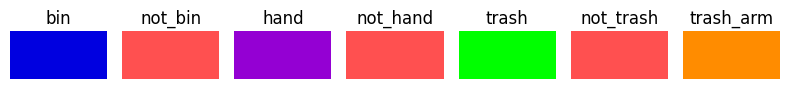

In [ ]:
# Visualizing what the colors look like using matplotlub
import matplotlib.pyplot as plt
import numpy as np

# Normalize RGB values to 0-1 range
def normalize_rgb(rgb_tuple):
  return tuple(x/255 for x in rgb_tuple)

# Turn colors into normalized RGB values for matplotlib
colours_and_labels_rgb = [(key, normalize_rgb(value)) for key, value in colour_palette.items()]

# Create figure and axis
fig, ax = plt.subplots(1, 7, figsize=(8, 1))

# Flatten the axis array for easier iteration
ax = ax.flatten()

# Plot each color square
for idx, (label, color) in enumerate(colours_and_labels_rgb):
  ax[idx].add_patch(plt.Rectangle(xy=(0,0),
                   width=1,
                   height=1,
                   facecolor=color))
  ax[idx].set_title(label)
  ax[idx].set_xlim(0, 1)
  ax[idx].set_ylim(0, 1)
  ax[idx].axis('off')

plt.tight_layout()
plt.show()

#### **Plotting a single image and visualizing the boxes**


##### **Creating helper function to help with visualization**
- `half_image` - half the image size.
- `half_boxes` - half the the bounding boxes by 2.

In [ ]:
from PIL import Image

def half_image(image: Image.Image) -> Image.Image:
  """
  Resizes a given input image by half and returns the smaller version.
  """
  return image.resize(size=(image.size[0] // 2, image.size[1] // 2))

def half_boxes(boxes):
  """
  Half an array/tensor boxes andreturns them. Necessary for plotting them on a half-sized image.

  e.g.:
  boxes = [100, 100, 100, 100]
  half_boxes = half_boxes(boxes)
  print(half_boxes)

  >>> [50, 50, 50, 50]
  """
  if isinstance(boxes, list):
    # If boxes are list of lists, then multiple boxes are present
    for box in boxes:
      if isinstance(box, list):
        return [[coordinate // 2 for coordinate in box] for box in boxes]
      else:
        return [coordinate // 2 for coordinate in boxes]

  if isinstance(boxes, np.ndarray):
    return (boxes // 2)

  if isinstance(boxes, torch.Tensor):
    return (boxes // 2)

# Test the functions
image_test = dataset['train'][45]['image']
image_test_half = half_image(image_test)
print(f"Original image size: {image_test.size} | Half image size: {image_test_half.size}")

boxes_test_list = [100, 100, 100, 100]
print(f"Original boxes: {boxes_test_list} | Half boxes: {half_boxes(boxes_test_list)}")

boxes_test_torch = torch.tensor([100.0, 100.0, 100.0, 100.0])
print(f"Original boxes: {boxes_test_torch} | Half boxes: {half_boxes(boxes_test_torch)}")

Original image size: (960, 1280) | Half image size: (480, 640)
Original boxes: [100, 100, 100, 100] | Half boxes: [50, 50, 50, 50]
Original boxes: tensor([100., 100., 100., 100.]) | Half boxes: tensor([50., 50., 50., 50.])


In [ ]:
image_test_boxes = dataset['train'][89]['annotations']['bbox']
image_test_boxes_half = half_boxes(image_test_boxes)
image_test_boxes_half

[[272.0, 286.0, 205.0, 194.0],
 [196.0, 268.0, 118.0, 78.0],
 [89.0, 204.0, 308.0, 304.0]]

##### **Plotting bounding boxes on a single image step by step**

Showing training sample from index: 228
Boxes in XYWH format: tensor([[154., 275., 163., 105.]])

Boxes XYXY: tensor([[154., 275., 317., 380.]])

Label names: ['bin']

Colour codes: [(0, 0, 224)]



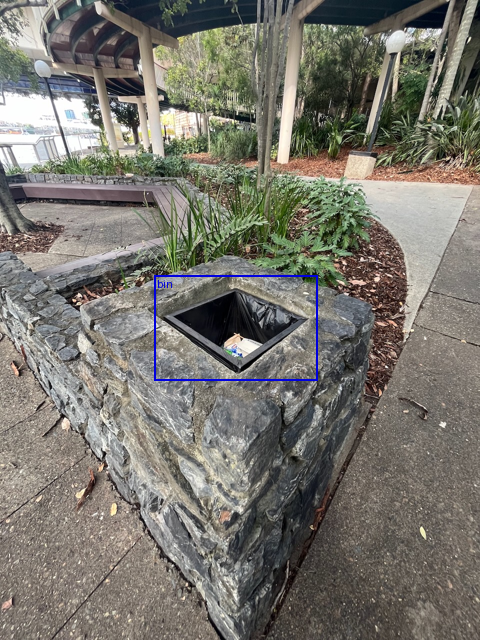

In [ ]:
import random
import torch
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image, pil_to_tensor

# Select a random sample from the dataset
random_index = random.randint(0, len(dataset['train']))
print(f"Showing training sample from index: {random_index}")
random_sample = dataset['train'][random_index]

# Get image and boxes from random sample
random_sample_image = random_sample['image']
random_sample_boxes = random_sample['annotations']['bbox']

# Half the image and boxes for space saving (all if the following code will work with/without ahlf size image)
half_random_sample_image = half_image(random_sample_image)
half_random_sample_boxes = half_boxes(random_sample_boxes)

# Turn box coordinates in a tensor
boxes_xywh = torch.tensor(half_random_sample_boxes)
print(f"Boxes in XYWH format: {boxes_xywh}\n")

# Convert boxes from XYWH -> XYXY
# torchvision.utils.draw_bounding_boxes requires input boxes in XYXY format (x_min, y_min, x_max, y_max)
boxes_xyxy = box_convert(boxes_xywh, "xywh", "xyxy")
print(f"Boxes XYXY: {boxes_xyxy}\n")

# Get label names of target boxes and colours to match
random_sample_label_names = [categories.feature.int2str(x) for x in random_sample["annotations"]["category_id"]]
random_sample_colours = [colour_palette[label_name] for label_name in random_sample_label_names]
print(f"Label names: {random_sample_label_names}\n")
print(f"Colour codes: {random_sample_colours}\n")

# Draw the boxes on the image as a tensor and then turn it into a PIL image
to_pil_image(
    draw_bounding_boxes(
        image=pil_to_tensor(half_random_sample_image),
        boxes=boxes_xyxy,
        colors=random_sample_colours,
        labels=random_sample_label_names,
        width=2,
        label_colors=random_sample_colours
    )
)

## Downloading the model from Hugging Face

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.module")

from transformers import AutoModelForObjectDetection

MODEL_NAME = "PekingU/rtdetr_v2_r50vd"

model = AutoModelForObjectDetection.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True, # Default, the model can be instantiated with a varying number of classes compared to what it may have been trained on
)

# model

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decod

In [ ]:
# model

In [ ]:
# Inspecting the model layers
print(f"ℹ️ Final classification layer: {model.class_embed}\n")
print(f"ℹ️ Final box regression layer: {model.bbox_embed}")

ℹ️ Final classification layer: ModuleList(
  (0-5): 6 x Linear(in_features=256, out_features=7, bias=True)
)

ℹ️ Final box regression layer: ModuleList(
  (0-5): 6 x RTDetrV2MLPPredictionHead(
    (layers): ModuleList(
      (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=4, bias=True)
    )
  )
)


In [ ]:
# Counting the number of parameters in the model
def count_parameters(model):
  """Takes in a PyTorch model and returns the number of parameters."""
  trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
  non_trainable_parameters = sum(p.numel() for p in model.parameters() if not p.requires_grad)
  total_parameters = sum(p.numel() for p in model.parameters())
  print(f"Total parameters: {total_parameters}")
  print(f"Trainable parameters (will be updated): {trainable_parameters:,}")
  print(f"Non-trainable parameters (will not be updated): {non_trainable_parameters}")

count_parameters(model)

Total parameters: 42741357
Trainable parameters (will be updated): 42,741,357
Non-trainable parameters (will not be updated): 0


### Creating a function to build the model

In [ ]:
from transformers import AutoModelForObjectDetection

# Setup the model
def create_model(pretrained_model_name_or_path: str=MODEL_NAME,
                 label2id: dict = label2id,
                 id2label: dict = id2label):
  """Creates and returns an instance of AutoModelForObjectDetection."""
  model = AutoModelForObjectDetection.from_pretrained(
      MODEL_NAME,
      label2id=label2id,
      id2label=id2label,
      ignore_mismatched_sizes=True,
  )
  return model

In [ ]:
# Create a new model instance
model = create_model()
# model

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decod

#### Trying to pass a single sample through the model

In [ ]:
# model.forward?

In [ ]:
# # Single forward pass with the model (even though it will output an error) data requires some preprocessing before being passed to the model
# random_sample_outputs = model(pixel_values=random_sample["image"],
#                               pixel_mask=None)
# random_sample_outputs

### Loading the model's processor

In [ ]:
from transformers import AutoImageProcessor

MODEL_NAME = "PekingU/rtdetr_v2_r50vd"

# Load the image processor
image_processor = AutoImageProcessor.from_pretrained(pretrained_model_name_or_path=MODEL_NAME,
                                                     use_fast=True)
image_processor

preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

RTDetrImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": false,
  "device": null,
  "disable_grouping": null,
  "do_center_crop": null,
  "do_convert_annotations": true,
  "do_convert_rgb": null,
  "do_normalize": false,
  "do_pad": false,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "RTDetrImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "input_data_format": null,
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "return_segmentation_masks": null,
  "return_tensors": null,
  "size": {
    "height": 640,
    "width": 640
  }
}

In [ ]:
# Set the image size
IMAGE_SIZE = 640

# Create a new instance of the image processor with the desired image size
image_processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    use_fast=True, # Use fast preprocessor
    format="coco_detection", # default
    do_convert_annotations=True, # converts to CXCYWH in the range[0, 1]
    size={"shortest_edge": IMAGE_SIZE,
          "longest_edge": IMAGE_SIZE},
    return_segmentaion_masks=True,
    do_pad=True, # make sure all images have 640 x 640
)

# docstring
# image_processor.preprocess?

# New image size
image_processor.size

{'shortest_edge': 640, 'longest_edge': 640}

In [ ]:
image_processor

RTDetrImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": false,
  "device": null,
  "disable_grouping": null,
  "do_center_crop": null,
  "do_convert_annotations": true,
  "do_convert_rgb": null,
  "do_normalize": false,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "RTDetrImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "input_data_format": null,
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "return_segmentation_masks": null,
  "return_tensors": null,
  "size": {
    "longest_edge": 640,
    "shortest_edge": 640
  }
}

In [ ]:
#### (Error)
# random_sample_preprocessed = image_processor.preprocess(images=random_sample["image"], annotations=random_sample["annotations"])

#### Preprocessing a single image


In [ ]:
random_sample_preprocessed_image_only = image_processor(images=random_sample['image'],
                                                        annotations=None,
                                                        masks_path=None, # no masks inputs
                                                        return_tensor="pt")
# print(random_sample_preprocessed_image_only)

# Print out the keys of the preprocessed image
print(random_sample_preprocessed_image_only.keys())

Unused or unrecognized kwargs: return_tensor.


KeysView({'pixel_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]]), 'pixel_values': tensor([[[[0.2588, 0.2784, 0.3137,  ..., 0.5647, 0.2353, 0.0941],
          [0.3294, 0.2902, 0.3255,  ..., 0.5020, 0.1490, 0.0471],
          [0.5608, 0.4235, 0.4275,  ..., 0.3804, 0.0549, 0.0235],
          ...,
          [0.5216, 0.4157, 0.4824,  ..., 0.4157, 0.4196, 0.3804],
          [0.4627, 0.4588, 0.4784,  ..., 0.4118, 0.3961, 0.3922],
          [0.4824, 0.5451, 0.4784,  ..., 0.4392, 0.3529, 0.3490]],

         [[0.3059, 0.3216, 0.3529,  ..., 0.5765, 0.2549, 0.1137],
          [0.3608, 0.3216, 0.3490,  ..., 0.5216, 0.1765, 0.0784],
          [0.5725, 0.4314, 0.4314,  ..., 0.4078, 0.0941, 0.0667],
          ...,
          [0.4784, 0.3725, 0.4392,  ..., 0.3804, 0.3843, 0.3451],
          [0.4157, 0.4157, 0.4353,  ..., 

- `pixel_values` - the processed pixel values of the input image.
- `pixel_mask` (optional) - a mask multiplier for the pixel values as to whether they should be paid attention to or not (0 - pixel value should be ignored by the model, 1 - pixel value should be paid attention to by the model).

In [ ]:
# print(random_sample_preprocessed_image_only["pixel_values"][0])

print(f"ℹ️ Original image shape: {random_sample['image'].size} -> [width, height]")
print(f"ℹ️ Preprocessed image shape: {random_sample_preprocessed_image_only['pixel_values'].shape} -> [batch_size, colour_channles, height, width]")

ℹ️ Original image shape: (960, 1280) -> [width, height]
ℹ️ Preprocessed image shape: torch.Size([1, 3, 640, 480]) -> [batch_size, colour_channles, height, width]


In [ ]:
print(random_sample_preprocessed_image_only["pixel_values"][0])

tensor([[[0.2588, 0.2784, 0.3137,  ..., 0.5647, 0.2353, 0.0941],
         [0.3294, 0.2902, 0.3255,  ..., 0.5020, 0.1490, 0.0471],
         [0.5608, 0.4235, 0.4275,  ..., 0.3804, 0.0549, 0.0235],
         ...,
         [0.5216, 0.4157, 0.4824,  ..., 0.4157, 0.4196, 0.3804],
         [0.4627, 0.4588, 0.4784,  ..., 0.4118, 0.3961, 0.3922],
         [0.4824, 0.5451, 0.4784,  ..., 0.4392, 0.3529, 0.3490]],

        [[0.3059, 0.3216, 0.3529,  ..., 0.5765, 0.2549, 0.1137],
         [0.3608, 0.3216, 0.3490,  ..., 0.5216, 0.1765, 0.0784],
         [0.5725, 0.4314, 0.4314,  ..., 0.4078, 0.0941, 0.0667],
         ...,
         [0.4784, 0.3725, 0.4392,  ..., 0.3804, 0.3843, 0.3451],
         [0.4157, 0.4157, 0.4353,  ..., 0.3765, 0.3608, 0.3569],
         [0.4392, 0.5020, 0.4353,  ..., 0.4039, 0.3176, 0.3137]],

        [[0.2902, 0.3098, 0.3451,  ..., 0.5490, 0.2431, 0.1255],
         [0.3412, 0.3020, 0.3333,  ..., 0.4941, 0.1686, 0.0863],
         [0.5451, 0.4078, 0.4078,  ..., 0.3843, 0.0863, 0.

##### Passing a single sample through the model

In [ ]:
random_sample_outputs = model(
    pixel_values=random_sample_preprocessed_image_only["pixel_values"], # model expects input [batch_size, colour_channels, image_height, image_width]
    # pixel_mask=random_sample_preprocessed_image_only["pixel_mask"], # some object detection models expect masks
)

random_sample_outputs

RTDetrV2ObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-4.3162, -2.1774, -0.8865,  ..., -1.7071, -3.9553, -0.1355],
         [-4.3360, -1.9463, -0.7433,  ..., -1.8514, -3.6413, -0.2003],
         [-2.7549, -3.1227, -0.8325,  ..., -0.6040, -3.7514, -1.1607],
         ...,
         [-3.9323, -2.0811, -0.7016,  ..., -1.4725, -3.4738, -0.5867],
         [-4.4421, -1.8072, -0.6822,  ..., -1.9621, -3.6998, -0.3509],
         [-3.1884, -3.5191, -1.6469,  ..., -1.9055, -2.6751, -0.3699]]],
       grad_fn=<SelectBackward0>), pred_boxes=tensor([[[0.3636, 0.9410, 0.2018, 0.1200],
         [0.2326, 0.9772, 0.0992, 0.0422],
         [0.1426, 0.1311, 0.1150, 0.0403],
         ...,
         [0.3815, 0.8951, 0.0730, 0.0793],
         [0.6704, 0.9789, 0.0591, 0.0390],
         [0.7754, 0.4174, 0.1485, 0.1733]]], grad_fn=<SelectBackward0>), auxiliary_outputs=None, last_hidden_state=tensor([[[ 0.5069,  1.0312, -0.0712,  ...,  0.0461, -0.3010, -0.4401],
         [ 0.6660,  0.6965,  0.19

In [ ]:
# Check the keys of the output
random_sample_outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'intermediate_hidden_states', 'intermediate_logits', 'intermediate_reference_points', 'encoder_last_hidden_state', 'init_reference_points', 'enc_topk_logits', 'enc_topk_bboxes', 'enc_outputs_class', 'enc_outputs_coord_logits'])

In [ ]:
# Inspect logits output shape
outputs_logits = random_sample_outputs.logits
print(f"Output logits shape: {outputs_logits.shape} -> [image, boxes, classes]")

Output logits shape: torch.Size([1, 300, 7]) -> [image, boxes, classes]


In [ ]:
# Inspect predicted boxes output shape
output_pred_boxes = random_sample_outputs.pred_boxes
print(f"Shape of the output predicted boxes: {output_pred_boxes.shape} -> [image, boxes, coordinates (CXCYWH)]")

Shape of the output predicted boxes: torch.Size([1, 300, 4]) -> [image, boxes, coordinates (CXCYWH)]


In [ ]:
output_pred_boxes

tensor([[[0.3636, 0.9410, 0.2018, 0.1200],
         [0.2326, 0.9772, 0.0992, 0.0422],
         [0.1426, 0.1311, 0.1150, 0.0403],
         ...,
         [0.3815, 0.8951, 0.0730, 0.0793],
         [0.6704, 0.9789, 0.0591, 0.0390],
         [0.7754, 0.4174, 0.1485, 0.1733]]], grad_fn=<SelectBackward0>)

In [ ]:
# Single example predicted bounding box coordinates
print(f"Example output box: {output_pred_boxes[:, 0, :][0].detach()} -> (CXCYWH)") # From the documentation

Example output box: tensor([0.3636, 0.9410, 0.2018, 0.1200]) -> (CXCYWH)


## Preprocessing annotations

In [ ]:
# # Preporcessing a single annotation pair (error out)
# image_processor.preprocess(
#     images=random_sample["image"],
#     annotations=random_sample["annotations"]
# )

In [ ]:
random_sample

{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 561,
 'annotations': {'file_name': ['35f36a69-e672-4c50-84a8-7cbd427b597a.jpeg'],
  'image_id': [561],
  'category_id': [0],
  'bbox': [[308.8999938964844,
    551.2999877929688,
    327.1000061035156,
    211.89999389648438]],
  'iscrowd': [0],
  'area': [69312.4921875]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}

In [ ]:
from dataclasses import dataclass, asdict
from typing import List, Tuple

# 1. Create a dataclass for a single COCO annotation
@dataclass
class SingleCOCOAnnotation:
  """An instance of single COCO annotation.

  Represents a COCO-formatted single instance of an object in an image.

  Attributes:
    image_id: Unique integer identifier for the image which the annotation belongs to.
    category_id: Integer identifier for the target object label/category (e.g. "0" for "bin").
    bbox: List of floats containing target bounding box coordinates in absolute XYWH format.
    area: Area of the target bounding box. Defaults to 0.0.
    iscrowd: Boolean flag (0 or 1) indicating whether the target is a crowd of objects.
  """
  image_id: int
  category_id: int
  bbox: List[float]
  area: float = 0.0
  iscrowd: int = 0

  # Making sure the bbox is always a list of 4 values (XYWH) -> Data validation using __post_init__ method
  def __post_init__(self):
    if len(self.bbox) != 4:
      raise ValueError(f"bbox should contain exactly 4 values, current length: {len(self.bbox)}")

# 2. Create a dataclass for a collection of COCO annotations for a single image
@dataclass
class ImageCOCOAnnotations:
  """A collection of COCO annotations for a single image_id.

  Attributes:
    image_id: Unique integer identifier for the image which the annotations belong to.
    annotations: List of SingleCOCOAnnotation instances.
  """
  image_id: int
  annotations: List[SingleCOCOAnnotation]

In [ ]:
# Inspecting the dataclass
# SingleCOCOAnnotation?

In [ ]:
# # Test error
# SingleCOCOAnnotation(image_id=42,
#                      category_id=0,
#                      bbox=[100, 100, 100])

# Test
SingleCOCOAnnotation(image_id=42,
                     category_id=0,
                     bbox=[100, 100, 100, 100])

SingleCOCOAnnotation(image_id=42, category_id=0, bbox=[100, 100, 100, 100], area=0.0, iscrowd=0)

#### Creating a function to format annotations as COCO format

In [ ]:
# Take in a unique image_id as well as lists of categories, areas, and bounding boxes
def format_image_annotations_as_coco(
    image_id: int,
    categories: List[int],
    areas: List[float],
    bboxes: List[Tuple[float, float, float]] # XYWH format ([x_top_left, y_top_left, width, height])
) -> dict:
  """Formats lists of image annotations into COCO format.

    Takes in parallel lists of categories, areas, and bounding boxes and
    then formats them into a COCO-style dictionary of annotations.

    Args:
        image_id: Unique integer identifier for an image.
        categories: List of integer category IDs for each annotation.
        areas: List of float areas for each annotation.
        bboxes: List of tuples containing bounding box coordinates in XYWH format
            ([x_top_left, y_top_left, width, height]).

    Returns:
        A dictionary of image annotations in COCO format with the following structure:
        {
            "image_id": int,
            "annotations": [
                {
                    "image_id": int,
                    "category_id": int,
                    "bbox": List[float],
                    "area": float
                },
                ...more annotations here
            ]
        }

    Note:
        All input lists much be the same length and in the same order.
        Otherwise, there will be mismatched annotations.
    """

  # Turn input lists into a list of dicts in SIngleCOCOAnnotation format
  coco_format_annotations = [
      asdict(SingleCOCOAnnotation(
          image_id=image_id,
          category_id=category,
          bbox=list(bbox),
          area=area,
      ))
      for category, area, bbox in zip(categories, areas, bboxes)
  ]

  # Return a dictionary of annotations with format {"image_id": ..., "annotations": [...]} (required COCO format)
  return asdict(ImageCOCOAnnotations(image_id=image_id,
                                     annotations=coco_format_annotations))

In [ ]:
# Initializing another random sample
random_sample = dataset["train"][86]
random_sample

{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 733,
 'annotations': {'file_name': ['15f51dde-4a5c-4bdc-863d-919b7ded8cd0.jpeg',
   '15f51dde-4a5c-4bdc-863d-919b7ded8cd0.jpeg',
   '15f51dde-4a5c-4bdc-863d-919b7ded8cd0.jpeg',
   '15f51dde-4a5c-4bdc-863d-919b7ded8cd0.jpeg'],
  'image_id': [733, 733, 733, 733],
  'category_id': [5, 0, 1, 0],
  'bbox': [[389.0, 597.7999877929688, 343.70001220703125, 152.60000610351562],
   [372.6000061035156,
    325.3999938964844,
    568.7000122070312,
    573.2999877929688],
   [34.5, 593.7999877929688, 460.5, 451.29998779296875],
   [128.5, 220.89999389648438, 407.29998779296875, 446.3999938964844]],
  'iscrowd': [0, 0, 0, 0],
  'area': [52448.62109375, 326035.71875, 207823.65625, 181818.71875]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}

In [ ]:
# random_sample['image']

In [ ]:
# Extract image_id, categories, areas and bboxes from the random sample
random_sample_image_id = random_sample["image_id"]
random_sample_categories = random_sample["annotations"]["category_id"]
random_sample_areas = random_sample["annotations"]["area"]
random_sample_bboxes = random_sample["annotations"]["bbox"]

# Format the random sample annotations as COCO format
random_sample_coco_annotations = format_image_annotations_as_coco(image_id=random_sample_image_id,
                                                                  categories=random_sample_categories,
                                                                  areas=random_sample_areas,
                                                                  bboxes=random_sample_bboxes)
random_sample_coco_annotations

{'image_id': 733,
 'annotations': [{'image_id': 733,
   'category_id': 5,
   'bbox': [389.0, 597.7999877929688, 343.70001220703125, 152.60000610351562],
   'area': 52448.62109375,
   'iscrowd': 0},
  {'image_id': 733,
   'category_id': 0,
   'bbox': [372.6000061035156,
    325.3999938964844,
    568.7000122070312,
    573.2999877929688],
   'area': 326035.71875,
   'iscrowd': 0},
  {'image_id': 733,
   'category_id': 1,
   'bbox': [34.5, 593.7999877929688, 460.5, 451.29998779296875],
   'area': 207823.65625,
   'iscrowd': 0},
  {'image_id': 733,
   'category_id': 0,
   'bbox': [128.5, 220.89999389648438, 407.29998779296875, 446.3999938964844],
   'area': 181818.71875,
   'iscrowd': 0}]}

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="The `max_size` parameter is deprecated*")

# Preprocess random sample image and associated annotations
random_sample_preprocessed = image_processor.preprocess(images=random_sample["image"],
                                                       annotations=random_sample_coco_annotations,
                                                       do_convert_annotations=True, # Convert annotations to normalized CXCYWH format
                                                       return_tensors="pt")

In [ ]:
random_sample_preprocessed

{'pixel_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]]), 'pixel_values': tensor([[[[0.5098, 0.6157, 0.4824,  ..., 0.6314, 0.7098, 0.7412],
          [0.6000, 0.7098, 0.6941,  ..., 0.7843, 0.6667, 0.6118],
          [0.7608, 0.9020, 0.8510,  ..., 0.7490, 0.5882, 0.5451],
          ...,
          [0.5020, 0.5216, 0.5451,  ..., 0.4196, 0.4196, 0.4275],
          [0.4863, 0.5608, 0.6039,  ..., 0.4706, 0.4471, 0.3843],
          [0.4784, 0.5608, 0.5882,  ..., 0.5412, 0.4549, 0.3569]],

         [[0.4745, 0.5765, 0.4471,  ..., 0.6157, 0.6941, 0.7216],
          [0.5686, 0.6745, 0.6627,  ..., 0.7686, 0.6510, 0.5922],
          [0.7373, 0.8784, 0.8314,  ..., 0.7412, 0.5647, 0.5176],
          ...,
          [0.4353, 0.4549, 0.4784,  ..., 0.3843, 0.3804, 0.3882],
          [0.4196, 0.4941, 0.5373,  ..., 0.4392, 0

In [ ]:
random_sample_preprocessed.keys()

KeysView({'pixel_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]]), 'pixel_values': tensor([[[[0.5098, 0.6157, 0.4824,  ..., 0.6314, 0.7098, 0.7412],
          [0.6000, 0.7098, 0.6941,  ..., 0.7843, 0.6667, 0.6118],
          [0.7608, 0.9020, 0.8510,  ..., 0.7490, 0.5882, 0.5451],
          ...,
          [0.5020, 0.5216, 0.5451,  ..., 0.4196, 0.4196, 0.4275],
          [0.4863, 0.5608, 0.6039,  ..., 0.4706, 0.4471, 0.3843],
          [0.4784, 0.5608, 0.5882,  ..., 0.5412, 0.4549, 0.3569]],

         [[0.4745, 0.5765, 0.4471,  ..., 0.6157, 0.6941, 0.7216],
          [0.5686, 0.6745, 0.6627,  ..., 0.7686, 0.6510, 0.5922],
          [0.7373, 0.8784, 0.8314,  ..., 0.7412, 0.5647, 0.5176],
          ...,
          [0.4353, 0.4549, 0.4784,  ..., 0.3843, 0.3804, 0.3882],
          [0.4196, 0.4941, 0.5373,  ..., 

In [ ]:
pprint.pprint(random_sample_preprocessed.labels)

[{'area': tensor([13112.1553, 81508.9297, 51955.9141, 45454.6797]),
  'boxes': tensor([[0.5842, 0.5266, 0.3580, 0.1192],
        [0.6843, 0.4782, 0.5924, 0.4479],
        [0.2758, 0.6402, 0.4797, 0.3526],
        [0.3460, 0.3470, 0.4243, 0.3487]]),
  'class_labels': tensor([5, 0, 1, 0]),
  'image_id': tensor([733]),
  'iscrowd': tensor([0, 0, 0, 0]),
  'orig_size': tensor([1280,  960]),
  'size': tensor([640, 480])}]


In [ ]:
# Inspect preprocessed image shape
print(f" Preprocessed image shape: {random_sample_preprocessed['pixel_values'].shape} -> [batch_size, colour_channels, height, width]")

 Preprocessed image shape: torch.Size([1, 3, 640, 480]) -> [batch_size, colour_channels, height, width]


### Performing postprocessing on a single image with an untrained model

In [ ]:
# Random sample outputs with preprocessed sample
random_sample_outputs = model(
    pixel_values=random_sample_preprocessed["pixel_values"], # model expects input [batch_size, color_channels, height, width]
    # pixel_mask=random_sample_preprocessed["pixel_mask"] #optional
)

# Inspect the output type
type(random_sample_outputs)

transformers.models.rt_detr_v2.modeling_rt_detr_v2.RTDetrV2ObjectDetectionOutput

In [ ]:
# Setting the threshold
THRESHOLD = 0.3 # Higher is for most confident outputs, lowering it to 0.3 say would produce handful outputs

# Post process a single output from the model
random_sample_outputs_postprocessed = image_processor.post_process_object_detection(
    outputs=random_sample_outputs,
    threshold=THRESHOLD, # boxes under threshold will be discarded (default 0.5)
    target_sizes=random_sample_preprocessed["labels"][0]["orig_size"].unsqueeze(0) # original input size required to be same number of input items in a list
)

random_sample_outputs_postprocessed

[{'scores': tensor([0.5579, 0.5452, 0.5417, 0.5404, 0.5356, 0.5332, 0.5328, 0.5303, 0.5280,
          0.5157, 0.5104, 0.5097, 0.5092, 0.5087, 0.5063, 0.5061, 0.5041, 0.5015,
          0.4991, 0.4988, 0.4985, 0.4977, 0.4973, 0.4963, 0.4945, 0.4888, 0.4877,
          0.4876, 0.4874, 0.4867, 0.4865, 0.4849, 0.4834, 0.4829, 0.4813, 0.4813,
          0.4796, 0.4778, 0.4776, 0.4770, 0.4752, 0.4752, 0.4751, 0.4745, 0.4733,
          0.4720, 0.4708, 0.4696, 0.4694, 0.4673, 0.4670, 0.4668, 0.4664, 0.4652,
          0.4648, 0.4648, 0.4643, 0.4642, 0.4622, 0.4622, 0.4610, 0.4598, 0.4597,
          0.4591, 0.4580, 0.4572, 0.4558, 0.4549, 0.4532, 0.4528, 0.4522, 0.4505,
          0.4502, 0.4499, 0.4493, 0.4488, 0.4481, 0.4479, 0.4459, 0.4453, 0.4452,
          0.4450, 0.4449, 0.4425, 0.4425, 0.4419, 0.4416, 0.4412, 0.4406, 0.4405,
          0.4402, 0.4393, 0.4389, 0.4386, 0.4377, 0.4377, 0.4377, 0.4361, 0.4358,
          0.4357, 0.4355, 0.4349, 0.4346, 0.4342, 0.4340, 0.4340, 0.4338, 0.4331,
      

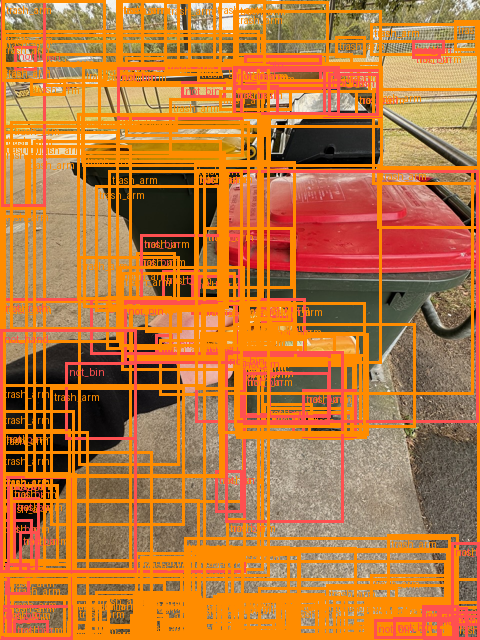

In [ ]:
# Get target image and boxes (half them for display purposes in the notebook)
image_to_plot = half_image(random_sample["image"])
boxes_to_plot = half_boxes(random_sample_outputs_postprocessed[0]["boxes"])

# Collect the boxes, scores and labels
random_sample_label_names = []
for result in random_sample_outputs_postprocessed:
  for score, label_id, box in zip(result["scores"],
                                  result["labels"],
                                  result["boxes"]):
    score, label = score.item(), label_id.item()
    box = [round(i, 2) for i in box.tolist()]

    # Printing out each prediction
    # print(f"ℹ️ {model.config.id2label[label]}: {score:.2f} {box}")

    random_sample_label_names.append(model.config.id2label[label])

# Get the list of colours to plot
random_sample_colours = [colour_palette[label_name] for label_name in random_sample_label_names]
# pprint.pprint(f"🏷️Label names: {random_sample_label_names}")
# pprint.pprint(f"🎨Colour codes: {random_sample_colours}")

# Create the outoput image with plotted boxes
output_image_with_boxes = to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(image_to_plot),
        boxes=boxes_to_plot,
        labels=random_sample_label_names,
        colors=random_sample_colours,
        width=3,
        label_colors=random_sample_colours,
    )
)

output_image_with_boxes

#### **_Reproducing postprocessed box scores by hand_**

In [ ]:
# Get output scores from post processed single output
output_scores = random_sample_outputs_postprocessed[0]["scores"]
len(output_scores), output_scores

(300,
 tensor([0.5579, 0.5452, 0.5417, 0.5404, 0.5356, 0.5332, 0.5328, 0.5303, 0.5280,
         0.5157, 0.5104, 0.5097, 0.5092, 0.5087, 0.5063, 0.5061, 0.5041, 0.5015,
         0.4991, 0.4988, 0.4985, 0.4977, 0.4973, 0.4963, 0.4945, 0.4888, 0.4877,
         0.4876, 0.4874, 0.4867, 0.4865, 0.4849, 0.4834, 0.4829, 0.4813, 0.4813,
         0.4796, 0.4778, 0.4776, 0.4770, 0.4752, 0.4752, 0.4751, 0.4745, 0.4733,
         0.4720, 0.4708, 0.4696, 0.4694, 0.4673, 0.4670, 0.4668, 0.4664, 0.4652,
         0.4648, 0.4648, 0.4643, 0.4642, 0.4622, 0.4622, 0.4610, 0.4598, 0.4597,
         0.4591, 0.4580, 0.4572, 0.4558, 0.4549, 0.4532, 0.4528, 0.4522, 0.4505,
         0.4502, 0.4499, 0.4493, 0.4488, 0.4481, 0.4479, 0.4459, 0.4453, 0.4452,
         0.4450, 0.4449, 0.4425, 0.4425, 0.4419, 0.4416, 0.4412, 0.4406, 0.4405,
         0.4402, 0.4393, 0.4389, 0.4386, 0.4377, 0.4377, 0.4377, 0.4361, 0.4358,
         0.4357, 0.4355, 0.4349, 0.4346, 0.4342, 0.4340, 0.4340, 0.4338, 0.4331,
         0.4329, 0.432

In [ ]:
print(f"Original input logits shape: {random_sample_outputs.logits.shape}\n")

# 1. Perform sigmoid on the logits to get prediction probabilities
output_scores_manual = random_sample_outputs.logits.sigmoid().flatten(start_dim=1)
print(f"ℹ️Manual output scores shape: {output_scores_manual.shape}")
print(f"🔟First 10 scores (in random order):\n{output_scores_manual[0][:10].detach().cpu()}\n")

# 2. Get top 100 scores
output_scores_manual_top_100, output_scores_manual_top_100_indices = torch.topk(input=output_scores_manual,
                                                                                k=100,
                                                                                dim=-1)
print(f"🔝Top 100 scores shape: {output_scores_manual_top_100.shape}")
print(f"🥇First top 100 score:{output_scores_manual_top_100[0][0].item():.4f}\n")

# 3. Find the values above the threshold and create a mask
output_scores_manual_mask = output_scores_manual_top_100 > THRESHOLD

# 4. Sort the top 100 scores which are above the threshold and sort them in a descending order to get the indices
output_scores_manual_filtered, output_scores_manual_filtered_indices = torch.sort(input=output_scores_manual_top_100[output_scores_manual_mask],
                                                                                  descending=True)

print(f"ℹ️Filtered scores shape: {output_scores_manual_filtered.shape}\n")
print(f"🎖️Filtered scores:{output_scores_manual_filtered[0].detach().cpu():.4f}")

Original input logits shape: torch.Size([1, 300, 7])

ℹ️Manual output scores shape: torch.Size([1, 2100])
🔟First 10 scores (in random order):
tensor([0.0109, 0.1150, 0.2831, 0.1788, 0.0570, 0.0531, 0.3534, 0.0117, 0.1253,
        0.2843])

🔝Top 100 scores shape: torch.Size([1, 100])
🥇First top 100 score:0.5579

ℹ️Filtered scores shape: torch.Size([100])

🎖️Filtered scores:0.5579


In [ ]:
# Comparing the original output scores to manual version
torch.isclose(input=output_scores[:len(output_scores_manual_filtered)],
              other=output_scores_manual_filtered,
              atol=1e-2)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

#### ***Producing postprocessed box labels by hand***

In [ ]:
# Get the model's predicted labels
output_labels = random_sample_outputs_postprocessed[0]["labels"]
print(f"Output labels shape: {len(output_labels)}")
print(f"Output labels:\n{output_labels}")

Output labels shape: 300
Output labels:
tensor([6, 6, 6, 6, 2, 6, 2, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2, 6, 6, 6,
        2, 6, 6, 2, 6, 2, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 2, 6, 6,
        6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2,
        6, 6, 6, 6, 6, 2, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2, 6, 6, 6,
        6, 2, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 2,
        6, 6, 6, 6, 6, 2, 6, 6, 6, 2, 2, 6, 6, 6, 6, 6, 6, 2, 2, 6, 6, 6, 2, 6,
        2, 2, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 2, 4, 6, 6, 6, 6, 6, 6, 2, 2, 2,
        6, 6, 6, 6, 6, 6, 2, 6, 2, 6, 6, 6, 6, 2, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6,
        2, 6, 6, 6, 6, 6, 6, 2, 2, 6, 2, 2, 6, 6, 2, 2, 6, 6, 6, 2, 6, 2, 2, 6,
        2, 6, 2, 4, 2, 2, 6, 6, 6, 2, 2, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 2, 6, 2,
        6, 6, 4, 2, 6, 2, 6, 6, 6, 6, 2, 2, 6, 6, 4, 6, 2, 6, 6, 2, 6, 6, 2, 2,


In [ ]:
output_scores_manual_top_100_indices

tensor([[1287,   62, 1462, 2029, 1682,  846, 1871,  853,  384, 1560,  209,  216,
          198, 1420,  902, 1840, 1994,  468, 1805, 1749, 1315,  181,  398, 1126,
         1322,  482, 2008, 1546,  356,  632,  769, 1105, 1665,  307, 1833, 1714,
         1154,  111,  692,  965,  804, 1353, 1721, 1483, 2074,  258,   34, 1000,
          366, 1476,  454, 1829,  587,  380, 1049,  720, 1308,  121, 1455, 1448,
          132,  601,  608, 1133,  335,  153, 1525,  212, 1259,  506,  391,  748,
          671,  489, 1959, 1906,  839, 1693,   20,  650, 1357, 2064,  272, 1742,
          552,  863,   97, 1602, 1588,   69, 1910, 1245,  240,  867,  776,  247,
         1952, 1791,  461,  265]])

In [ ]:
random_sample_outputs.logits.shape

torch.Size([1, 300, 7])

In [ ]:
# 1. Get the number of classes
num_classes = random_sample_outputs.logits.shape[2]
print(f"Found total number of classes: {num_classes}")

# 2. Modulo the output_scores_manual_top_100_indices by the number of classes to get the predicted class (this is because the outputs above were flattened with .flatten(1))
output_labels_manual = output_scores_manual_top_100_indices % num_classes

# 3. Find the top labels which pass the score threshold
output_labels_manual_filtered = output_labels_manual[0][output_scores_manual_filtered_indices]

output_labels.shape, output_labels_manual_filtered.shape

Found total number of classes: 7


(torch.Size([300]), torch.Size([100]))

In [ ]:
# Making sure these labels are equivalent to the postprocessed labels
output_labels[:len(output_labels_manual_filtered)] == output_labels_manual_filtered

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

##### ***Reproducing postprocessed box coordinates by hand***

In [ ]:
# These are in absolute XYXY format
output_boxes = random_sample_outputs_postprocessed[0]["boxes"]
print(f"Output boxes shape: {output_boxes.shape}")
print(f"Output (absolute XYXY format), first 10:\n{output_boxes[:10]}")

Output boxes shape: torch.Size([300, 4])
Output (absolute XYXY format), first 10:
tensor([[ 905.2859, 1240.0623,  960.3162, 1280.1809],
        [ 904.2251, 1230.3785,  960.7559, 1278.2301],
        [ 875.9067, 1223.1530,  959.3089, 1278.7588],
        [ 428.7435, 1247.9690,  482.6272, 1280.9658],
        [  20.3612,  969.0840,  116.5477, 1127.4351],
        [ 881.5040, 1203.6572,  959.6265, 1278.0337],
        [ 310.7300,  668.4604,  345.4508,  705.3348],
        [ 892.3129, 1212.1180,  959.6092, 1279.6113],
        [  27.1917,  994.9990,   79.7887, 1133.4048],
        [  26.5123, 1240.2247,   96.1180, 1300.5328]],
       grad_fn=<SliceBackward0>)


In [ ]:
# Get model output raw boxes, in format; normalized CXCYWH format
output_boxes_manual_cxcywh = random_sample_outputs.pred_boxes[0]
print(f"Output boxes manual shape: {output_boxes_manual_cxcywh.shape}")
print(f"Output boxes manual (normalized CXCYWH format), first 10:\n{output_boxes_manual_cxcywh[:10]}")

Output boxes manual shape: torch.Size([300, 4])
Output boxes manual (normalized CXCYWH format), first 10:
tensor([[0.5463, 0.5212, 0.0561, 0.0326],
        [0.5621, 0.5190, 0.0324, 0.0209],
        [0.5948, 0.6031, 0.1892, 0.0995],
        [0.2712, 0.3891, 0.3897, 0.3904],
        [0.8201, 0.9665, 0.2525, 0.0615],
        [0.5996, 0.1226, 0.2022, 0.0329],
        [0.3560, 0.0590, 0.2102, 0.1164],
        [0.2686, 0.5638, 0.2097, 0.3271],
        [0.9713, 0.9799, 0.0589, 0.0374],
        [0.2760, 0.4726, 0.5464, 0.8365]], grad_fn=<SliceBackward0>)


In [ ]:
# 1. Normalize the indices by dividing by the number of classes (this is because we flattened our logits tensor in a previous step)
output_scores_manual_top_100_indicies_normalized = output_scores_manual_top_100_indices[0] // num_classes
output_scores_manual_top_100_indicies_normalized

tensor([183,   8, 208, 289, 240, 120, 267, 121,  54, 222,  29,  30,  28, 202,
        128, 262, 284,  66, 257, 249, 187,  25,  56, 160, 188,  68, 286, 220,
         50,  90, 109, 157, 237,  43, 261, 244, 164,  15,  98, 137, 114, 193,
        245, 211, 296,  36,   4, 142,  52, 210,  64, 261,  83,  54, 149, 102,
        186,  17, 207, 206,  18,  85,  86, 161,  47,  21, 217,  30, 179,  72,
         55, 106,  95,  69, 279, 272, 119, 241,   2,  92, 193, 294,  38, 248,
         78, 123,  13, 228, 226,   9, 272, 177,  34, 123, 110,  35, 278, 255,
         65,  37])

In [ ]:
# 2. Filter boxes for top 100 above the target threshold
output_boxes_manual_above_threshold_cxcywh = output_boxes_manual_cxcywh[output_scores_manual_top_100_indicies_normalized]

print(f"[INFO] Output boxes manual above threshold shape: {output_boxes_manual_above_threshold_cxcywh.shape}")
print(f"[INFO] Output boxes manual above threshold (normalized CXCYWH format), \
showing first 10:\n{output_boxes_manual_above_threshold_cxcywh[:10, :]}")

[INFO] Output boxes manual above threshold shape: torch.Size([100, 4])
[INFO] Output boxes manual above threshold (normalized CXCYWH format), showing first 10:
tensor([[0.9717, 0.9845, 0.0573, 0.0313],
        [0.9713, 0.9799, 0.0589, 0.0374],
        [0.9558, 0.9773, 0.0869, 0.0434],
        [0.4747, 0.9879, 0.0561, 0.0258],
        [0.0713, 0.8190, 0.1002, 0.1237],
        [0.9589, 0.9694, 0.0814, 0.0581],
        [0.3418, 0.5366, 0.0362, 0.0288],
        [0.9645, 0.9733, 0.0701, 0.0527],
        [0.0557, 0.8314, 0.0548, 0.1081],
        [0.0639, 0.9925, 0.0725, 0.0471]], grad_fn=<SliceBackward0>)


In [ ]:
from torchvision.ops import box_convert

# 3. Convert the model's predicted boxes from CXCYWH to XYXY format
output_boxes_manual_above_threshold_xyxy = box_convert(boxes=output_boxes_manual_above_threshold_cxcywh,
                                                       in_fmt="cxcywh",
                                                       out_fmt="xyxy")
print(f"[INFO] Output boxes manual above threshold (absolute XYXY format):\n{output_boxes_manual_above_threshold_xyxy[:10]}")

[INFO] Output boxes manual above threshold (absolute XYXY format):
tensor([[0.9430, 0.9688, 1.0003, 1.0001],
        [0.9419, 0.9612, 1.0008, 0.9986],
        [0.9124, 0.9556, 0.9993, 0.9990],
        [0.4466, 0.9750, 0.5027, 1.0008],
        [0.0212, 0.7571, 0.1214, 0.8808],
        [0.9182, 0.9404, 0.9996, 0.9985],
        [0.3237, 0.5222, 0.3598, 0.5510],
        [0.9295, 0.9470, 0.9996, 0.9997],
        [0.0283, 0.7773, 0.0831, 0.8855],
        [0.0276, 0.9689, 0.1001, 1.0160]], grad_fn=<SliceBackward0>)


In [ ]:
# 4. Get the original input image size (required for box conversion)
random_sample_image_original_size= random_sample_preprocessed["labels"][0]["orig_size"]
print(f"[INFO] Image original size: {random_sample_image_original_size} (height, width)")

[INFO] Image original size: tensor([1280,  960]) (height, width)


In [ ]:
# 5. Get normalized box coordinates to absolute pixel values
# Get the original image heigth and width
original_height, original_width = random_sample_image_original_size

# Create an XYXY tensor to multiply by
original_dimensions = torch.tensor([original_width, # x1
                                    original_height, # y1
                                    original_width, # x2
                                    original_height # y2
                                    ])

# Convert the boxes to absolute pixel values
output_boxes_manual_above_threshold_xyxy_absolute = output_boxes_manual_above_threshold_xyxy * original_dimensions
output_boxes_manual_above_threshold_xyxy_absolute[:10]

tensor([[ 905.2859, 1240.0623,  960.3162, 1280.1809],
        [ 904.2251, 1230.3785,  960.7559, 1278.2301],
        [ 875.9067, 1223.1530,  959.3089, 1278.7588],
        [ 428.7435, 1247.9690,  482.6272, 1280.9658],
        [  20.3612,  969.0840,  116.5477, 1127.4351],
        [ 881.5040, 1203.6572,  959.6265, 1278.0337],
        [ 310.7300,  668.4604,  345.4508,  705.3348],
        [ 892.3129, 1212.1180,  959.6092, 1279.6113],
        [  27.1917,  994.9990,   79.7887, 1133.4048],
        [  26.5123, 1240.2247,   96.1180, 1300.5328]],
       grad_fn=<SliceBackward0>)

In [ ]:
# 6. Order boxes in same order as labels and scores (descending based on score)
output_boxes_manual_sorted = output_boxes_manual_above_threshold_xyxy_absolute[output_scores_manual_filtered_indices]
output_boxes_manual_sorted[:10]

tensor([[ 905.2859, 1240.0623,  960.3162, 1280.1809],
        [ 904.2251, 1230.3785,  960.7559, 1278.2301],
        [ 875.9067, 1223.1530,  959.3089, 1278.7588],
        [ 428.7435, 1247.9690,  482.6272, 1280.9658],
        [  20.3612,  969.0840,  116.5477, 1127.4351],
        [ 881.5040, 1203.6572,  959.6265, 1278.0337],
        [ 310.7300,  668.4604,  345.4508,  705.3348],
        [ 892.3129, 1212.1180,  959.6092, 1279.6113],
        [  27.1917,  994.9990,   79.7887, 1133.4048],
        [  26.5123, 1240.2247,   96.1180, 1300.5328]],
       grad_fn=<SliceBackward0>)

In [ ]:
# 7. Check for equivalence between original postprocessed boxes and manually processed boxes
torch.all(input=output_boxes[:100] == output_boxes_manual_sorted)

tensor(True)

### ***Plotting model's first box predictions on an image***

Labels with scores: ['Pred: trash_arm (0.5579)', 'Pred: trash_arm (0.5452)', 'Pred: trash_arm (0.5417)']...



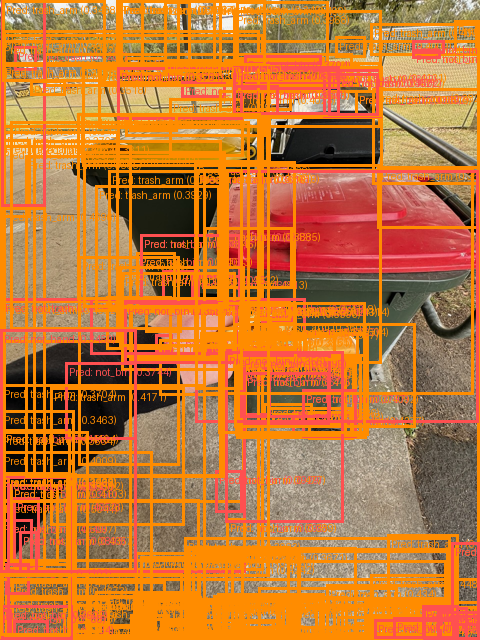

In [ ]:
# 1. Extract scores, labels and boxes
random_sample_pred_scores = random_sample_outputs_postprocessed[0]["scores"]
random_sample_pred_labels = random_sample_outputs_postprocessed[0]["labels"] # ID no.
random_sample_pred_boxes = half_boxes(random_sample_outputs_postprocessed[0]["boxes"])

# 2. Create a list of labels and colours to plot on the images/boxes
random_sample_pred_labels_to_plot = [f"Pred: {id2label[label_pred.item()]} ({round(score_pred.item(), 4)})" for label_pred, score_pred in zip(random_sample_pred_labels, random_sample_pred_scores)]
random_sample_pred_colours = [colour_palette[id2label[label_pred.item()]] for label_pred in random_sample_pred_labels]

print(f"Labels with scores: {random_sample_pred_labels_to_plot[:3]}...\n")

# 3. Plot the random sample image with randomly predicted boxes (these will be ppor since the model is not trained on the data yet)
to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=half_image(random_sample["image"])),
        boxes=random_sample_pred_boxes, # XYXY format required
        labels=random_sample_pred_labels_to_plot,
        colors=random_sample_pred_colours,
        width=3
    )
)

## **Preparing data at scale**
- **Splitting the data** into train, validation and test sets
- **Preprocesing multiple samples at a time** by iterating over groups of samples.
- **Collate samples into batches** - passing batches of data to the model.

### Splitting the data into training and test sets

In [ ]:
from datasets import load_dataset

# Loading the original dataset
dataset = load_dataset(path="mrdbourke/trashify_manual_labelled_images")
original_dataset_length = len(dataset["train"])
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 1128
    })
})

In [ ]:
# 1. Split the data into "train" and "test" splits
dataset_split = dataset['train'].train_test_split(test_size=0.3, seed=1234) # 70/30

# 2. Split the test split into "test" and "validation" splits
dataset_test_val_split = dataset_split['test'].train_test_split(test_size=0.66, seed=1234) #  val/test split

# Create "train" split from 1
dataset['train'] = dataset_split['train']

# Create a "validation" and "test" split from 2
dataset["validation"] = dataset_test_val_split["train"]
dataset["test"] = dataset_test_val_split["test"]

# Ensure split lengths add to equal original dataset length (otherwuse there's a mismatch somewhere)
assert original_dataset_length == len(dataset["train"]) + len(dataset["validation"]) + len(dataset["test"]), "Total dataset split lengths don't equal original dataset length, is there a mismatch? Please try reloading the original dataset and re-running this cell."

# Split dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 789
    })
    validation: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 115
    })
    test: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 224
    })
})

#### ***Preprocesing multiple samples at a time***

In [ ]:
dataset['train'][9]

{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 810,
 'annotations': {'file_name': ['3acc376c-c6bf-45b8-809a-86c96b5f39b7.jpeg',
   '3acc376c-c6bf-45b8-809a-86c96b5f39b7.jpeg',
   '3acc376c-c6bf-45b8-809a-86c96b5f39b7.jpeg'],
  'image_id': [810, 810, 810],
  'category_id': [5, 1, 0],
  'bbox': [[452.0, 657.9000244140625, 102.9000015258789, 100.5999984741211],
   [393.79998779296875,
    713.5999755859375,
    314.8999938964844,
    421.6000061035156],
   [267.6000061035156,
    293.6000061035156,
    444.3999938964844,
    565.4000244140625]],
  'iscrowd': [0, 0, 0],
  'area': [10351.740234375, 132761.84375, 251263.765625]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}

In [ ]:
dataset['train'][0:4]

{'image': [<PIL.Image.Image image mode=RGB size=960x1280>,
  <PIL.Image.Image image mode=RGB size=960x1280>,
  <PIL.Image.Image image mode=RGB size=960x1280>,
  <PIL.Image.Image image mode=RGB size=960x1280>],
 'image_id': [321, 17, 780, 669],
 'annotations': [{'file_name': ['24b4d767-bcb4-4502-8f5e-40290da559f4.jpeg',
    '24b4d767-bcb4-4502-8f5e-40290da559f4.jpeg',
    '24b4d767-bcb4-4502-8f5e-40290da559f4.jpeg',
    '24b4d767-bcb4-4502-8f5e-40290da559f4.jpeg'],
   'image_id': [321, 321, 321, 321],
   'category_id': [5, 1, 4, 0],
   'bbox': [[277.1000061035156, 534.5, 199.5, 240.8000030517578],
    [21.299999237060547, 639.0, 361.3999938964844, 531.4000244140625],
    [177.0, 767.5999755859375, 62.099998474121094, 92.4000015258789],
    [69.5, 352.79998779296875, 734.4000244140625, 649.4000244140625]],
   'iscrowd': [0, 0, 0, 0],
   'area': [48039.6015625, 192047.953125, 5738.0400390625, 476919.375]},
  {'file_name': ['d3bd8c1b-2847-40d6-b5fc-e872abce990c.jpeg',
    'd3bd8c1b-2847-40

[Augmentation/transforms](https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html)

In [ ]:
# 1. Take in a list of examples, image processor and optional transforms(data augmentation)
def preprocess_batch(examples, image_processor, transforms=None):
  """
    Preprocesses a batch of image data with annotations for object detection models.

    This function takes a batch of examples in a custom dataset format, extracts images and
    their corresponding annotations, and converts them into a format suitable for model training
    or inference using the provided image processor.

    Args:
        examples (dict): A dictionary containing the batch data with the following structure:
            - "image" (List[PIL.Image.Image]): List of PIL Image objects
            - "image_id" (List[int]): List of unique image identifiers
            - "annotations" (List[dict]): List of annotation dictionaries, where each contains:
                - "file_name" (List[str]): List of image filenames
                - "image_id" (List[int]): List of image identifiers
                - "category_id" (List[int]): List of object category IDs
                - "bbox" (List[List[float]]): List of bounding boxes as [x, y, width, height]
                - "iscrowd" (List[int]): List of crowd indicators (0 or 1)
                - "area" (List[float]): List of object areas
            - "label_source" (List[str]): List of label sources
            - "image_source" (List[str]): List of image sources

        image_processor: An image processor object to preprocess images for model input.
            For example, can be `transformers.RTDetrDetrImageProcessor`.

        transforms (optional): Image and annotations transforms for data augmentation.
            Defaults to None.

    Returns:
        dict: Preprocessed batch with images and annotations converted to tensors
            in the format required for a `transformers.RTDetrV2ForObjectDetection` model.

    Note:
        The `format_image_annotations_as_coco` function converts the input annotation format to COCO
        format before applying the image_processor. This is required as the image_processor is designed
        to handle COCO format annotations.
  """
  # 2. Create empty lists to store images and annotations
  images = []
  coco_annotations = []

  # 3. Extract the image, image_id and annotations from the examples
  for image, image_id, annotations_dict in zip(examples["image"], examples["image_id"], examples["annotations"]):
    # 4. Create lists of annotaion attributes
    bbox_list = annotations_dict["bbox"]
    category_list = annotations_dict["category_id"]
    area_list = annotations_dict["area"]

    # 5. Optionally apply a transform/augmentation here
    if transforms:
      pass

    # 6. Format the ammotations into COCO format
    coco_format_annotations = format_image_annotations_as_coco(
        image_id = image_id,
        categories = category_list,
        areas = area_list,
        bboxes = bbox_list
    )

    # 7. Add images/annotations to their respective lists
    images.append(image) #
    coco_annotations.append(coco_format_annotations)

  # 8. Apply the image processor to a list of images and annotations
  preprocessed_batch = image_processor.preprocess(images=images,
                                                  annotations=coco_annotations,
                                                  return_tensors="pt")

  return preprocessed_batch

In [ ]:
preprocessed_samples = preprocess_batch(dataset['train'][:4], image_processor)
preprocessed_samples.keys()

KeysView({'pixel_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]]), 'pixel_values': tensor([[[[0.4902, 0.4902, 0.5216,  ..., 0.1373, 0.1451

In [ ]:
print(f"Shape of preprocessed samples: {preprocessed_samples['pixel_values'].shape} -> [batch_size, color_channels, height, width]")

Shape of preprocessed samples: torch.Size([4, 3, 640, 480]) -> [batch_size, color_channels, height, width]


#### ***Applying the function to each data split***
- Using `with_transform()` for the transformations to be applied on the fly when the split datasets are called.

In [ ]:
# Create a partial function for preprocessing
from functools import partial

# The preprocess_batch function now accesses image_processor from the surrounding scope
preprocess_batch_partial = partial(preprocess_batch, image_processor=image_processor, transforms=None)

preprocess_batch_partial

functools.partial(<function preprocess_batch at 0x7dd88396dee0>, image_processor=RTDetrImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": false,
  "device": null,
  "disable_grouping": null,
  "do_center_crop": null,
  "do_convert_annotations": true,
  "do_convert_rgb": null,
  "do_normalize": false,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "RTDetrImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "input_data_format": null,
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "return_segmentation_masks": null,
  "return_tensors": null,
  "size": {
    "longest_edge": 640,
    "shortest_edge": 640
  }
}
, transforms=None)

In [ ]:
# Create a copy of the original dataset
processed_dataset = dataset.copy()

# Apply the preprocessing function to the datasets
processed_dataset["train"] = dataset['train'].with_transform(transform=preprocess_batch_partial)
processed_dataset["validation"] = dataset['validation'].with_transform(transform=preprocess_batch_partial)
processed_dataset["test"] = dataset['test'].with_transform(transform=preprocess_batch_partial)

In [ ]:
# Get an item from the dataset (in will be preprocessed when fetched)
processed_dataset['train'][38]

{'pixel_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'pixel_values': tensor([[[0.6235, 0.6275, 0.6353,  ..., 0.6902, 0.7961, 0.8471],
          [0.6314, 0.6314, 0.6392,  ..., 0.7569, 0.8588, 0.8863],
          [0.6549, 0.6431, 0.6471,  ..., 0.8549, 0.9216, 0.9451],
          ...,
          [0.8118, 0.8157, 0.8157,  ..., 0.5098, 0.5137, 0.4824],
          [0.8118, 0.8078, 0.8196,  ..., 0.5020, 0.5020, 0.4980],
          [0.8118, 0.8157, 0.8157,  ..., 0.4784, 0.4706, 0.4902]],
 
         [[0.7725, 0.7765, 0.7843,  ..., 0.7137, 0.8039, 0.8431],
          [0.7804, 0.7804, 0.7882,  ..., 0.7725, 0.8588, 0.8745],
          [0.8039, 0.7961, 0.8000,  ..., 0.8549, 0.9059, 0.9255],
          ...,
          [0.6706, 0.6745, 0.6745,  ..., 0.5412, 0.5490, 0.5137],
          [0.6706, 0.6706, 0.6784,  ..., 0.5294, 0.

In [ ]:
batch_size_to_get = 32
print(f"Shape of preprocessed images: {processed_dataset['train'][:batch_size_to_get]['pixel_values'].shape} -> [batch_size, colour_channels, height, width]")

Shape of preprocessed images: torch.Size([32, 3, 640, 480]) -> [batch_size, colour_channels, height, width]


In [ ]:
# model(processed_dataset["train"][:batch_size_to_get]['pixel_mask_values'])

### **Creating a collation function**

In [ ]:
from typing import List, Dict, Any

def data_collate_function(preprocessed_batch: List[Dict[str, Any]]) -> Dict[str, Any]:
  """Stacks together groups of preprocessed samples into batches for our model.

    Args:
        preprocessed_batch: A list of dictionaries where each dictionary represnets a preprocessed sample.

    Returns:
        collated_data: A dictionary containing the batched data ready in the format our model
            is expecting. The dictionary has the following keys:
                - "pixel_values": A stacked tensor of preprocessed pixel values.
                - "labels": A list of label dictionaries.
                - "pixel_mask": (Optional) A stacked tensor of pixel masks (this will be present
                    only if the input contains a "pixel_mask" key.
    """
  collated_data = {} # model wants a dictionary input

  # Stack together a collection of pixel_values tensors
  collated_data["pixel_values"] = torch.stack([sample["pixel_values"] for sample in preprocessed_batch])

  # Get the labels
  collated_data["labels"] = [sample["labels"] for sample in preprocessed_batch]

  # If there is a pixel_mask key return the pixel_mask as well
  if "pixel_mask" in preprocessed_batch[0]:
    collated_data["pixel_mask"] = torch.stack([sample["pixel_mask"] for sample in preprocessed_batch])

  return collated_data

In [ ]:
%%time

example_collated_data_batch = data_collate_function(processed_dataset["train"].select(range(8)))
example_collated_data_batch.keys()

CPU times: user 1.39 s, sys: 29.5 ms, total: 1.42 s
Wall time: 1.57 s


dict_keys(['pixel_values', 'labels', 'pixel_mask'])

In [ ]:
# Check shapes of batched preprocessed samples
print(f"ℹ️ Batch of pixel value shapes: {example_collated_data_batch['pixel_values'].shape}")
print(f"ℹ️ Batch of labels: {example_collated_data_batch['labels']}")
if "pixel_mask" in example_collated_data_batch:
    print(f"ℹ️ Batch of pixel masks: {example_collated_data_batch['pixel_mask'].shape}")

ℹ️ Batch of pixel value shapes: torch.Size([8, 3, 640, 480])
ℹ️ Batch of labels: [{'size': tensor([640, 480]), 'image_id': tensor([321]), 'class_labels': tensor([5, 1, 4, 0]), 'boxes': tensor([[0.3926, 0.5116, 0.2078, 0.1881],
        [0.2104, 0.7068, 0.3765, 0.4152],
        [0.2167, 0.6358, 0.0647, 0.0722],
        [0.4549, 0.5293, 0.7650, 0.5073]]), 'area': tensor([ 12009.9004,  48011.9883,   1434.5100, 119229.8438]), 'iscrowd': tensor([0, 0, 0, 0]), 'orig_size': tensor([1280,  960])}, {'size': tensor([640, 480]), 'image_id': tensor([17]), 'class_labels': tensor([5, 0, 1, 4, 4, 4, 4, 4, 4, 4, 4]), 'boxes': tensor([[0.4115, 0.5412, 0.3281, 0.3135],
        [0.6158, 0.5063, 0.5126, 0.4210],
        [0.2222, 0.7363, 0.4258, 0.4174],
        [0.7751, 0.2243, 0.1941, 0.1241],
        [0.2380, 0.2042, 0.1072, 0.0745],
        [0.0728, 0.2160, 0.1451, 0.0887],
        [0.4919, 0.1888, 0.0378, 0.0296],
        [0.4904, 0.1226, 0.2745, 0.0934],
        [0.9162, 0.1846, 0.0347, 0.0449],
     

In [ ]:
# %%time

# # Try pass a batch through model (note: this will be relatively slow if model is on the CPU)
# model = create_model()

# # Set the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Move the model to the device
# model.to(device)

# # Move the batch to the device
# example_collated_data_batch["pixel_values"] = example_collated_data_batch["pixel_values"].to(device)
# if "pixel_mask" in example_collated_data_batch:
#     example_collated_data_batch["pixel_mask"] = example_collated_data_batch["pixel_mask"].to(device)
# example_collated_data_batch["labels"] = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in label.items()} for label in example_collated_data_batch["labels"]]


# # example_batch_outputs = model(example_collated_data_batch["pixel_values"])
# example_batch_outputs = model(example_collated_data_batch["pixel_values"])
# # example_batch_outputs # uncomment for full output
# example_batch_outputs.keys()

# # If you still encounter OOM errors, try reducing the BATCH_SIZE in the TrainingArguments cell.

In [ ]:
%%time

# Try pass a batch through model (note: this will be relatively slow if model is on the CPU)
model = create_model()

# example_batch_outputs = model(example_collated_data_batch["pixel_values"])
example_batch_outputs = model(example_collated_data_batch["pixel_values"])
# example_batch_outputs # uncomment for full output
example_batch_outputs.keys()

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decod

CPU times: user 16.8 s, sys: 7.61 s, total: 24.4 s
Wall time: 36.2 s


odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'intermediate_hidden_states', 'intermediate_logits', 'intermediate_reference_points', 'encoder_last_hidden_state', 'init_reference_points', 'enc_topk_logits', 'enc_topk_bboxes', 'enc_outputs_class', 'enc_outputs_coord_logits'])

## TrainingArguments and Trainer instance to train the model

In [ ]:
# 1. Create a model instance
model = create_model()

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decod

In [ ]:
from pathlib import Path
# 2. Make a models directory for saving models
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# 3. Create an instance of TrainingArguments to pass to a Trainer
from transformers import TrainingArguments
import os

# Defining some of the hyperparameters
BATCH_SIZE = 8 # Reduced from 16 to 8 to avoid OOM error
NUM_WORKERS = os.cpu_count()
NUM_EPOCHS = 10

LEARNING_RATE = 1e-4 # multipliers on the size of gradient updates during training
WEIGHT_DECAY = 1e-4 # prevents model weights from getting too large by applying a small penalty over time
MAX_GRAD_NORM = 0.1 # prevents gradient from getting too large during training
WARMUP_RATIO = 0.05 # learning rate warmup from 0 to learning_rate as a ratio of total steps (e.g. 0.05 = 5% of total steps)

# Create directory to save models to
OUTPUT_DIR = Path(models_dir, "rt_detrv2_finetuned_trash_box_detector_v1")
print(f"ℹ️ Saving the model to: {OUTPUT_DIR}")

# Create TrainingArguments to pass Trainer
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    max_grad_norm=MAX_GRAD_NORM,
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    warmup_ratio=WARMUP_RATIO,
    # warmup_steps=2000, # number of warmup steps from 0 to learning_rate (overrides warmup_ratio)
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    fp16=True, # mixed precision training
    dataloader_num_workers=NUM_WORKERS,
    eval_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False, # minimizing eval_loss (lower is better)
    report_to="none", # don't save experiments to third party service
    push_to_hub=False,
    eval_do_concat_batches=False,
    # save_safetensors=False,
)

ℹ️ Saving the model to: models/rt_detrv2_finetuned_trash_box_detector_v1


#### (optional) Setting up an optimizer for multiple learning rates

In [ ]:
from transformers import Trainer

# Create lists for different kinds of parameters
backbone_parameters = []
other_parameters = []

# Loop through different model parameters and extract different model sections
for name, param in model.model.named_parameters():
  if "backbone" in name:
    # print(f"Backbone parameter: {name}")
    backbone_parameters.append(param)
  else:
    # print(f"Other parameter: {name}")
    other_parameters.append(param)

print(f"ℹ️Number of backbone parameter modules: {len(backbone_parameters)}")
print(f"ℹ️Number of other parameter modules: {len(other_parameters)}")

BACKBONE_LEARNING_RATE = 1e-5
DETECTION_HEAD_LEARNING_RATE = 1e-4

print(f"ℹ️Using learning rate for backbone: {BACKBONE_LEARNING_RATE}")
print(f"ℹ️Using learning rate for other parameters and detection head: {DETECTION_HEAD_LEARNING_RATE}")

# Setup a custom subclass of Trainer to use different learning rates for different parts of the model
class CustomTrainer(Trainer):
  def create_optimizer(self):
    self.optimizer = torch.optim.AdamW([
        {"params": backbone_parameters, "lr": BACKBONE_LEARNING_RATE},
        {"params": other_parameters, "lr": DETECTION_HEAD_LEARNING_RATE}
    ], weight_decay=1e-4)
    return self.optimizer


ℹ️Number of backbone parameter modules: 55
ℹ️Number of other parameter modules: 363
ℹ️Using learning rate for backbone: 1e-05
ℹ️Using learning rate for other parameters and detection head: 0.0001


### **Creating an evaluation function**

In [ ]:
# Function to convert bounding boxes to XYXY absolute format from noramlized CXCYWH format
from torchvision.ops import box_convert

def convert_bbox_cxcywh_to_xyxy_absolute(boxes, image_size_target):
  """
    Converts CXCYWH normalized boxes to XYXY absolute boxes.

    The output of our preprocess method puts boxes in CXCYWH format.

    But our evaluation metric torchmetrics.detection.mean_ap.MeanAveragePrecision expects
        boxes in XYXY absolute format.

    Args:
        boxes (torch.Tensor): A tensor of shape (N, 4) where N is the number of boxes and each box is in CXCYWH format.
        image_size_target (tuple): A tuple containing the target image size as (height, width).

    Returns:
        torch.Tensor: A tensor of shape (N, 4) where each box is converted to XYXY absolute format.
  """
  # Convert normalized CXCYWH -> absolute XYXY format required for evaluation
  boxes = box_convert(boxes, "cxcywh", "xyxy")

  # Convert normalized box coordinates to absolute pixel values based on the target size
  image_height = image_size_target[0]
  image_width = image_size_target[1]
  boxes = boxes * torch.tensor([image_width,
                                image_height,
                                image_width,
                                image_height])
  return boxes

In [ ]:
# Creating an evaluation function to test the model's performance
import numpy as np
from typing import Optional, Mapping
from transformers import EvalPrediction
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# 1. Create a datclass to hold model's outputs
@dataclass
class ModelOutput:
  logits: torch.Tensor
  pred_boxes: torch.Tensor

# 2. Create a compute_metrics function which takes in EvalPrediction and other required parameters
@torch.no_grad()
def compute_metrics(evaluation_results:EvalPrediction, # come out of the Trainer.evaluate method
                    image_processor:AutoImageProcessor,
                    threshold:float=0.0,
                    id2label:Optional[Mapping[int, str]]=None) -> Mapping[str, float]:
  """
    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:
        evaluation_results (EvalPrediction): Predictions and targets from evaluation.
        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:
        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
  """
  # 3. Extract predictions and targets from EvalPrediction
  predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

  # 4. Get a list of image sizes, processed targets and processed predictions
  image_sizes = []
  post_processed_targets = []
  post_processed_predictions = []

  # 5. Collect target attributes in the required format for metric computation
  for batch in targets:
    # Collect ground truth image size for predictions post processing
    batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch])) # turn into a list of numpy arrays first then to tensors
    image_sizes.append(batch_image_sizes)

    # Collect targets in the required format for metric computation
    for image_target in batch:
      # Get boxes and convert from CXCYWH to XYXY
      boxes = torch.tensor(image_target["boxes"])
      boxes = convert_bbox_cxcywh_to_xyxy_absolute(boxes,
                                                   image_target["orig_size"])
      # Get labels
      labels = torch.tensor(image_target["class_labels"])
      # Append box and label pairs in format required for MeanAveragePrecision class
      post_processed_targets.append({"boxes": boxes,
                                     "labels": labels})

  # 6. Collect predictions in the required format for metric computation
  for pred_batch, target_sizes in zip(predictions, image_sizes):
    pred_batch_loss, pred_batch_logits, pred_batch_boxes = pred_batch[0], pred_batch[1], pred_batch[2]

    model_output = ModelOutput(logits=torch.tensor(pred_batch_logits),
                               pred_boxes=torch.tensor(pred_batch_boxes))

    # Post process the model outputs
    post_processed_output = image_processor.post_process_object_detection(outputs=model_output,
                                                                          threshold=threshold,
                                                                          target_sizes=target_sizes) # target sizes required to shape boxes in correct ratio of original image

    # Extend post_processed_ouput
    post_processed_predictions.extend(post_processed_output)

  # 7. Compute mAP (mean average precision)
  max_detection_thresholds = [1, 10, 100] #
  metric = MeanAveragePrecision(box_format="xyxy",
                                class_metrics=True,
                                max_detection_thresholds=max_detection_thresholds)
  metric.warn_on_many_detections = False # don't output a warning when large amount of detections come out
  metric.update(post_processed_predictions,
                post_processed_targets)
  metrics = metric.compute()

  # print(metrics) # for troubleshooting

  # 8. Extract list of per class metrics with separate metric for each class
  classes = metrics.pop("classes")
  map_per_class = metrics.pop("map_per_class")

  # mAR per class (Mean Average Recall)
  mar_per_class = metrics.pop("mar_100_per_class")

  # 9. Prepare metrics per class in the form of a dict with metric names : values
  for class_id, class_map, class_mar in zip(classes, map_per_class, mar_per_class):
    class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
    metrics[f"map_{class_name}"] = class_map

    # Optional: mAR@100 per class
    metrics[f"mar_100_{class_name}"] = class_mar

  # 10. Round metrics for suitable visual output
  metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

  # Optional: print metrics dict for troubleshooting
  # print(metrics)

  return metrics

# 11. Create a partial function for compute_metrics funtion
eval_compute_metrics_fn = partial(
    compute_metrics,
    image_processor=image_processor,
    threshold=0.0,
    id2label=id2label
)

### Training the model with Trainer

In [ ]:
from transformers import Trainer

# Setup instance of Trainer
model_v1_trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collate_function,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    compute_metrics=eval_compute_metrics_fn
)

# Train the model
model_v1_results = model_v1_trainer.train()

There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'class_embed.3.weight', 'class_embed.3.bias', 'class_embed.4.weight', 'class_embed.4.bias', 'class_embed.5.weight', 'class_embed.5.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias', 'bbox_embed.3.layers.0.weight', 'bbox_embed.3.layers.0.bias', 'bbox_embed.3.layers.1.weight', 'bbox_embed.3.l

#### **Plotting model's loss curves**

In [ ]:
# model_v1_trainer.state.log_history

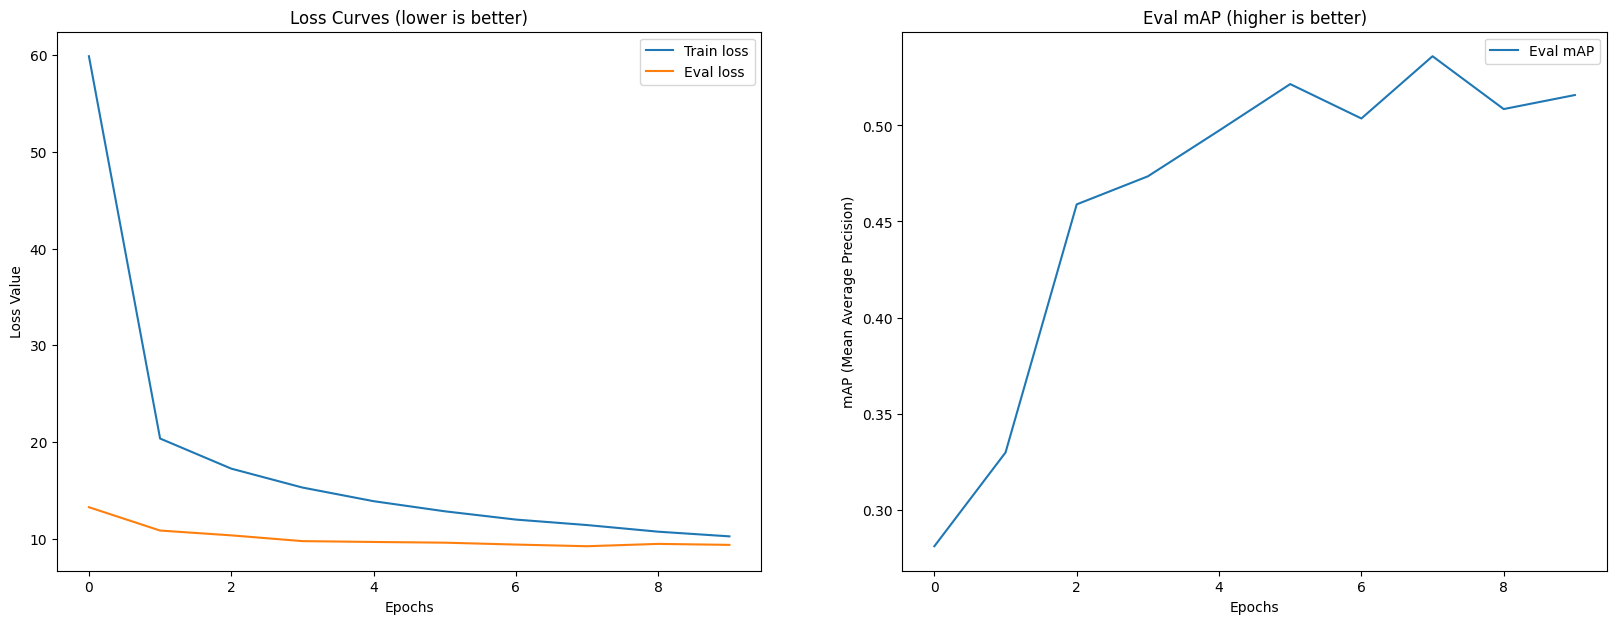

In [ ]:
import matplotlib.pyplot as plt

log_history = model_v1_trainer.state.log_history

# Extract loss values
train_loss = [item["loss"] for item in log_history if "loss" in item]
eval_loss =  [item["eval_loss"] for item in log_history if "eval_loss" in item]

# Extract mAP values
eval_map = [item["eval_map"] for item in log_history if "eval_map" in item]

# Plot loss curves and mAP
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
ax[0].plot(train_loss, label="Train loss")
ax[0].plot(eval_loss, label="Eval loss")
ax[0].set_title("Loss Curves (lower is better)")
ax[0].set_ylabel("Loss Value")
ax[0].set_xlabel("Epochs")
ax[0].legend()

ax[1].plot(eval_map, label="Eval mAP")
ax[1].set_title("Eval mAP (higher is better)")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("mAP (Mean Average Precision)")
ax[1].legend();

- ***Would training it for longer epochs make it better?***

## Making predictions on test dataset

In [ ]:
# Making predictions using transformers.Trainer.predict method
test_dataset_preds = model_v1_trainer.predict(test_dataset=processed_dataset["test"])
# test_dataset_preds

In [ ]:
# Predictions come in the same batch size as the training setup
test_dataset_prediction_outputs = test_dataset_preds.predictions
test_dataset_label_outputs = test_dataset_preds.label_ids

print(f"[INFO] Found {len(test_dataset_prediction_outputs)} batches of prediction samples and {len(test_dataset_label_outputs)} batches of labels.")

[INFO] Found 28 batches of prediction samples and 28 batches of labels.


In [ ]:
# Get the first batch of test prediction samples
test_batch_metrics = test_dataset_prediction_outputs[0][0] # metrics come at index 0 in the form of a dictionary
test_batch_logits = test_dataset_prediction_outputs[0][1] # logits come at index 1 in a numpy array
test_batch_boxes = test_dataset_prediction_outputs[0][2] # predicted boxes come at index 2 in a numpy array

print(f"[INFO] Metrics keys: {test_batch_metrics.keys()}")
print(f"[INFO] Test predictions single batch logits shape: {test_batch_logits.shape} -> (batch_size, num_predictions, logit_per_class)")
print(f"[INFO] Test predictions single batch boxes shape: {test_batch_boxes.shape} -> (batch_size, num_predictions, box_coordinates)")
print(f"[INFO] Test logits type: {type(test_batch_logits)} | Test boxes type: {type(test_batch_boxes)}")

[INFO] Metrics keys: dict_keys(['loss_vfl', 'loss_bbox', 'loss_giou', 'loss_vfl_aux_0', 'loss_bbox_aux_0', 'loss_giou_aux_0', 'loss_vfl_aux_1', 'loss_bbox_aux_1', 'loss_giou_aux_1', 'loss_vfl_aux_2', 'loss_bbox_aux_2', 'loss_giou_aux_2', 'loss_vfl_aux_3', 'loss_bbox_aux_3', 'loss_giou_aux_3', 'loss_vfl_aux_4', 'loss_bbox_aux_4', 'loss_giou_aux_4', 'loss_vfl_aux_5', 'loss_bbox_aux_5', 'loss_giou_aux_5'])
[INFO] Test predictions single batch logits shape: (8, 300, 7) -> (batch_size, num_predictions, logit_per_class)
[INFO] Test predictions single batch boxes shape: (8, 300, 4) -> (batch_size, num_predictions, box_coordinates)
[INFO] Test logits type: <class 'numpy.ndarray'> | Test boxes type: <class 'numpy.ndarray'>


In [ ]:
# We can stack these together to get the full outputs
test_dataset_pred_logits = []
test_dataset_pred_boxes = []

for test_pred_batch in test_dataset_prediction_outputs:
    test_dataset_pred_logits.append(test_pred_batch[1]) # logits come at index 1
    test_dataset_pred_boxes.append(test_pred_batch[2]) # boxes come at index 2

test_dataset_pred_logits = torch.tensor(np.concatenate(test_dataset_pred_logits))
test_dataset_pred_boxes = torch.tensor(np.concatenate(test_dataset_pred_boxes))

print(f"[INFO] Test predictions logits shape: {test_dataset_pred_logits.shape} -> (num_samples, num_predictions, logit_per_class)")
print(f"[INFO] Test predictions boxes shape: {test_dataset_pred_boxes.shape} -> (num_samples, num_predictions, box_coordinates - CXCYWH normalize format)")

[INFO] Test predictions logits shape: torch.Size([224, 300, 7]) -> (num_samples, num_predictions, logit_per_class)
[INFO] Test predictions boxes shape: torch.Size([224, 300, 4]) -> (num_samples, num_predictions, box_coordinates - CXCYWH normalize format)


#### Evaluate test predictions

In [ ]:
# Create an empty list for preds
test_dataset_prediction_dicts = []

# Threshold for prediction probabilities
THRESHOLD = 0.0

# Iterate through prediction logits and prediction boxes
for i in range(len(test_dataset_pred_boxes)):
  pred_logits = test_dataset_pred_logits[i].unsqueeze(0) # add a batch of dimension 1
  pred_boxes = test_dataset_pred_boxes[i].unsqueeze(0)

  # Get original size of input image (required for post processing)
  original_size = processed_dataset["test"][i]["labels"]["orig_size"].unsqueeze(0) # add a batch dimension of 1

  # Collect prediction outputs
  pred_outputs = ModelOutput(logits=pred_logits, pred_boxes=pred_boxes)

  # Post process (boxes will automatically be output in XYXY absolute format)
  pred_outputs_postprocessed = image_processor.post_process_object_detection(outputs=pred_outputs,
                                                                            threshold=THRESHOLD,
                                                                            target_sizes=original_size)
  # Create a dictionary of post processed outputs
  prediction_dict = {"boxes": pred_outputs_postprocessed[0]["boxes"],
                     "scores": pred_outputs_postprocessed[0]["scores"],
                     "labels": pred_outputs_postprocessed[0]["labels"]}
  # Append the dictionary
  test_dataset_prediction_dicts.append(prediction_dict)

print(f"ℹ️Number of prediction dicts: {len(test_dataset_prediction_dicts)}")
print(f"ℹ️Example prediction dict:")
test_dataset_prediction_dicts[0]

ℹ️Number of prediction dicts: 224
ℹ️Example prediction dict:


{'boxes': tensor([[ 2.4669e+02,  5.7726e+02,  5.2136e+02,  9.2278e+02],
         [ 1.5982e+02,  2.6150e+02,  6.1933e+02,  7.7459e+02],
         [ 1.3484e+02,  7.9933e+02,  3.7419e+02,  1.1302e+03],
         ...,
         [ 5.2143e+02,  6.3914e+02,  7.1810e+02,  1.1851e+03],
         [ 2.9048e+02, -3.9099e-01,  4.5395e+02,  1.6464e+02],
         [ 2.5380e+02,  5.7462e+02,  5.2450e+02,  9.2770e+02]]),
 'scores': tensor([0.9033, 0.8680, 0.7335, 0.5803, 0.3934, 0.3516, 0.2256, 0.1718, 0.1683,
         0.1583, 0.1569, 0.1548, 0.1546, 0.1499, 0.1472, 0.1454, 0.1437, 0.1380,
         0.1338, 0.1305, 0.1279, 0.1267, 0.1235, 0.1234, 0.1202, 0.1193, 0.1168,
         0.1162, 0.1158, 0.1114, 0.1097, 0.1088, 0.1088, 0.1069, 0.1061, 0.1054,
         0.1048, 0.1047, 0.1039, 0.1034, 0.1030, 0.1027, 0.1023, 0.1003, 0.0998,
         0.0969, 0.0964, 0.0962, 0.0953, 0.0942, 0.0942, 0.0937, 0.0933, 0.0932,
         0.0922, 0.0922, 0.0911, 0.0909, 0.0896, 0.0893, 0.0891, 0.0891, 0.0887,
         0.0883, 0.0

In [ ]:
## Creating a target dictionary
# Create a list for targets
test_dataset_target_dicts = []

# Iterate through test samples
for test_sample in processed_dataset["test"]:
  # Extract the truth labels
  sample_labels = test_sample["labels"]

  # Extract class labels and boxes
  truth_class_labels = sample_labels["class_labels"]
  truth_boxes = sample_labels["boxes"]

  # Get original size of image
  original_size = sample_labels["orig_size"] # height, witdh

  # Convert boxes from CXCYWH normalized to XYXY absolute
  truth_boxes_xyxy = convert_bbox_cxcywh_to_xyxy_absolute(boxes=truth_boxes,
                                                          image_size_target=original_size)
  # Create target truth dictionary
  target_dict = {"boxes": truth_boxes_xyxy,
                 "labels": truth_class_labels}
  # Append target dictionary
  test_dataset_target_dicts.append(target_dict)

print(f"ℹ️Number of target dictionaries: {len(test_dataset_target_dicts)}")
print(f"ℹ️Example target dictionary:")
test_dataset_target_dicts[0]

ℹ️Number of target dictionaries: 224
ℹ️Example target dictionary:


{'boxes': tensor([[  97.8000,   93.3000,  275.3000,  194.9000],
         [ 342.2000,  572.6000,  692.2000,  916.7999],
         [ 185.2000,  803.0000,  489.6000, 1174.5999],
         [ 219.4000,  259.1000,  818.1000,  843.6000]]),
 'labels': tensor([2, 5, 1, 0])}

> Creating an instance of `MeanAveragePrecision` and use it to calculate metrics comparing predictions to ground truth.

In [ ]:
# Compare predictions to targets
from torchmetrics.detection.mean_ap import  MeanAveragePrecision

# Instantiate mAP metric instance
map_metric = MeanAveragePrecision(iou_type="bbox",
                                  class_metrics=True) # so as to get a breakdown of mAP and mAR for each class (class metric for each class)
map_metric.warn_on_many_detections = False # hide extra detection warnings

# Update metric with list of pred dicts and list of target dicts
map_metric.update(preds=test_dataset_prediction_dicts,
                  target=test_dataset_target_dicts)

# Calculate the metric
test_metric_outputs = map_metric.compute()

# Extract per class metrics
test_map_per_class = test_metric_outputs.pop("map_per_class")
test_mar_per_class = test_metric_outputs.pop("mar_100_per_class")

test_metric_outputs

{'map': tensor(0.3806),
 'map_50': tensor(0.5244),
 'map_75': tensor(0.4268),
 'map_small': tensor(0.3000),
 'map_medium': tensor(0.1304),
 'map_large': tensor(0.4038),
 'mar_1': tensor(0.4903),
 'mar_10': tensor(0.6382),
 'mar_100': tensor(0.6919),
 'mar_small': tensor(0.6000),
 'mar_medium': tensor(0.4460),
 'mar_large': tensor(0.7152),
 'classes': tensor([0, 1, 2, 3, 4, 5, 6], dtype=torch.int32)}

#### ***Visualizing test dataset evaluation metrics***

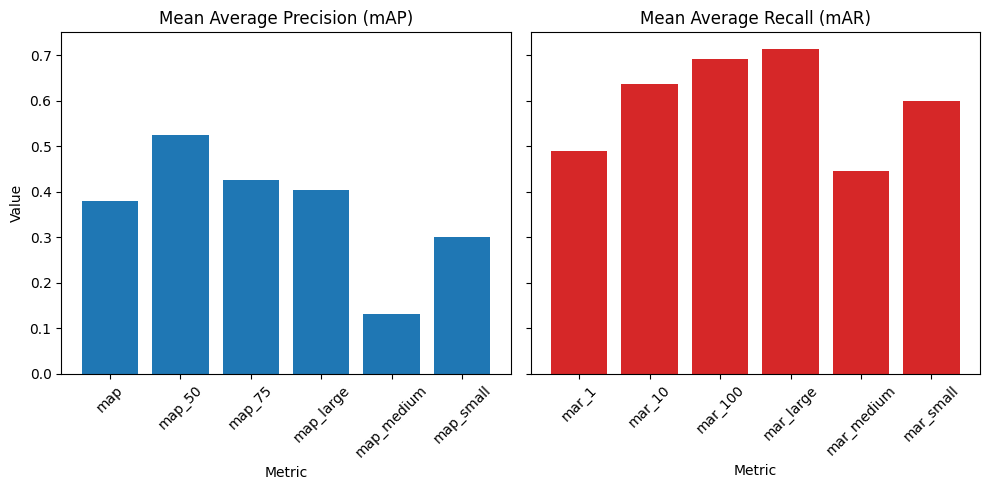

In [ ]:
import matplotlib.pyplot as plt

# Extract mAR and mAP metrics
test_map_metrics = {k: v for k, v in test_metric_outputs.items() if "map" in k}
test_mar_metrics = {k: v for k, v in test_metric_outputs.items() if "mar" in k}

# Get labels and values
test_map_labels, test_map_values = zip(*sorted(test_map_metrics.items()))
test_mar_labels, test_mar_values = zip(*sorted(test_mar_metrics.items()))

# Create a subplot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

# Add mAP values
ax[0].bar(test_map_labels, test_map_values)
ax[0].set_title("Mean Average Precision (mAP)")
ax[0].set_xlabel("Metric")
ax[0].set_ylabel("Value")
ax[0].tick_params(axis="x", rotation=45)

# mAR values
ax[1].bar(test_mar_labels, test_mar_values, color="tab:red")
ax[1].set_title("Mean Average Recall (mAR)")
ax[1].set_xlabel("Metric")
ax[1].tick_params(axis="x", rotation=45)

plt.tight_layout()

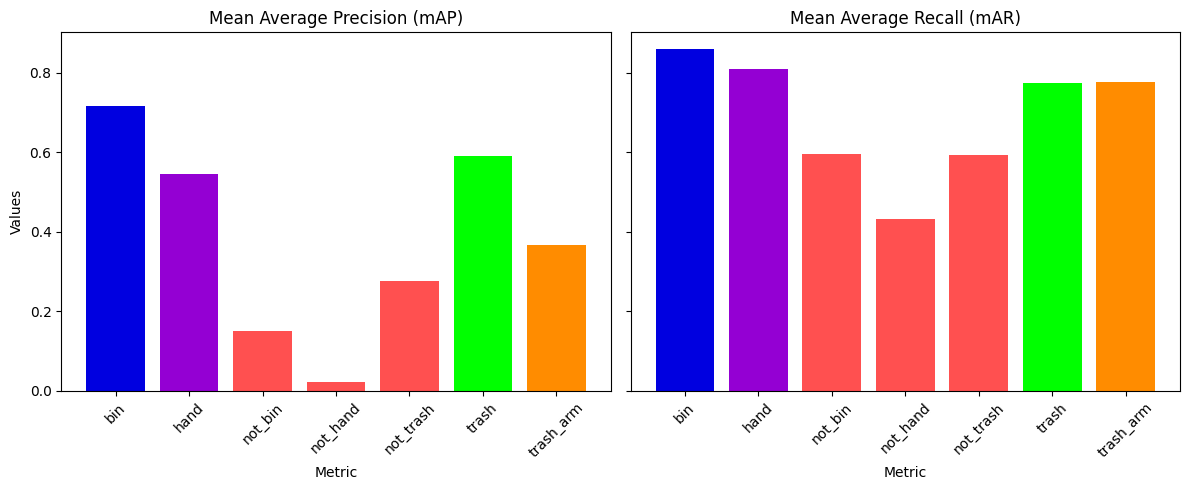

In [ ]:
# Visualizing per class values
# Map class names to metric values
test_map_per_class_dict = dict(zip(list(label2id.keys()), test_map_per_class))
test_mar_per_class_dict = dict(zip(list(label2id.keys()), test_mar_per_class))

# Get the labels and values
test_map_per_class_labels, test_map_per_class_values = zip(*sorted(test_map_per_class_dict.items()))
test_mar_per_class_labels, test_mar_per_class_values = zip(*sorted(test_mar_per_class_dict.items()))

# Create a list of RGB colour floats for matplotlib
label_to_colour_dict = {key: normalize_rgb(value) for key, value in colour_palette.items()}

colours_for_map = [label_to_colour_dict.get(label_name, (0.6, 0.6, 0.6)) for label_name in test_map_per_class_labels] # default to gray (0., 0.6, 0.6)
colours_for_mar = [label_to_colour_dict.get(label_name, (0.6, 0.6, 0.6)) for label_name in test_mar_per_class_labels] # default to gray (0., 0.6, 0.6)

# Create a subplot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)

# Add mAP values
ax[0].bar(test_map_per_class_labels,
          test_map_per_class_values,
          color=colours_for_map)
ax[0].set_title("Mean Average Precision (mAP)")
ax[0].set_ylabel("Values")
ax[0].set_xlabel("Metric")
ax[0].tick_params(axis="x", rotation=45)

# Add mAR values
ax[1].bar(test_mar_per_class_labels,
          test_mar_per_class_values,
          color=colours_for_mar)
ax[1].set_title("Mean Average Recall (mAR)")
ax[1].set_xlabel("Metric")
ax[1].tick_params(axis="x", rotation=45)

plt.tight_layout()

#### ***Visualizing one of the actual prediction***
- In case of an overlapping bounding boxes appearing on a single predicted item for the same class, the most confident one with the highest score can be the one displayed while the others are suppressed of lower scores by using `Non-Maximum Suppression (NMS)`

ℹ️Making predictions on test item with index: 28
⏲️Time taken to perform prediction: 0.065 seconds
ℹ️Labels with scores:
Pred: bin (0.9053)
Pred: trash (0.8368)
Pred: hand (0.5696)


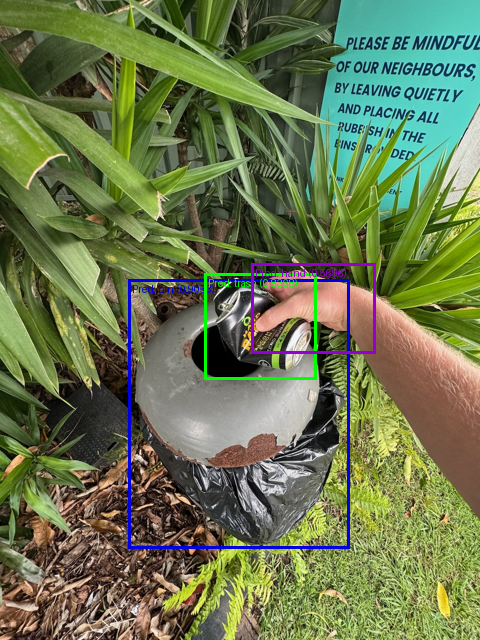

In [ ]:
import time

# Get the random sample from the test preds
random_test_pred_index = random.randint(0, len(processed_dataset["test"]))
print(f"ℹ️Making predictions on test item with index: {random_test_pred_index}")

# Get a random sample from the processed dataset
random_test_sample = processed_dataset["test"][random_test_pred_index]

# Do a single forward pass with the model
start_pred_time = time.time()
random_test_sample_outputs = model(pixel_values=random_test_sample["pixel_values"].unsqueeze(0).to("cuda"), # input of [batch_size, color_channels, height, width]
                                   pixel_mask=None)
print(f"⏲️Time taken to perform prediction: {round(time.time() - start_pred_time, 3)} seconds")

# Post process a random item from test preds
random_test_sample_outputs_postprocessed = image_processor.post_process_object_detection(
    outputs=random_test_sample_outputs,
    threshold=0.35, # prediction probability threshold for boxes (note: boxes from an untrained model will likely be bad)
    target_sizes=random_test_sample["labels"]["orig_size"].unsqueeze(0)
)

# Extract scores, labels and boxes
random_test_sample_pred_scores = random_test_sample_outputs_postprocessed[0]["scores"]
random_test_sample_pred_labels = random_test_sample_outputs_postprocessed[0]["labels"]
random_test_sample_pred_boxes = half_boxes(random_test_sample_outputs_postprocessed[0]["boxes"])

# Create a list of labels and colours to plot on the boxes
random_test_sample_pred_to_score_tuples = [(id2label[label_pred.item()], round(score_pred.item(), 4))
                                          for label_pred, score_pred in zip(random_test_sample_pred_labels, random_test_sample_pred_scores)]
random_test_sample_labels_to_plot = [f"Pred: {item[0]} ({item[1]})" for item in random_test_sample_pred_to_score_tuples]
random_test_sample_colours_to_plot = [colour_palette[item[0]] for item in random_test_sample_pred_to_score_tuples]

print(f"ℹ️Labels with scores:")
for label in random_test_sample_labels_to_plot:
  print(label)

# Plot the predicted boxes on the random test image
test_pred_box_image = to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=half_image(dataset["test"][random_test_pred_index]["image"])),
        boxes=random_test_sample_pred_boxes,
        colors=random_test_sample_colours_to_plot,
        labels=random_test_sample_labels_to_plot,
        width=3
    )
)

test_pred_box_image

#### ***Comparing model's predicted boxes to the ground truth boxes***
- Extracting the same test sample from the test dataset, plot the ground truth boxes on it and then create a side by side comparison of truth versus predictions.

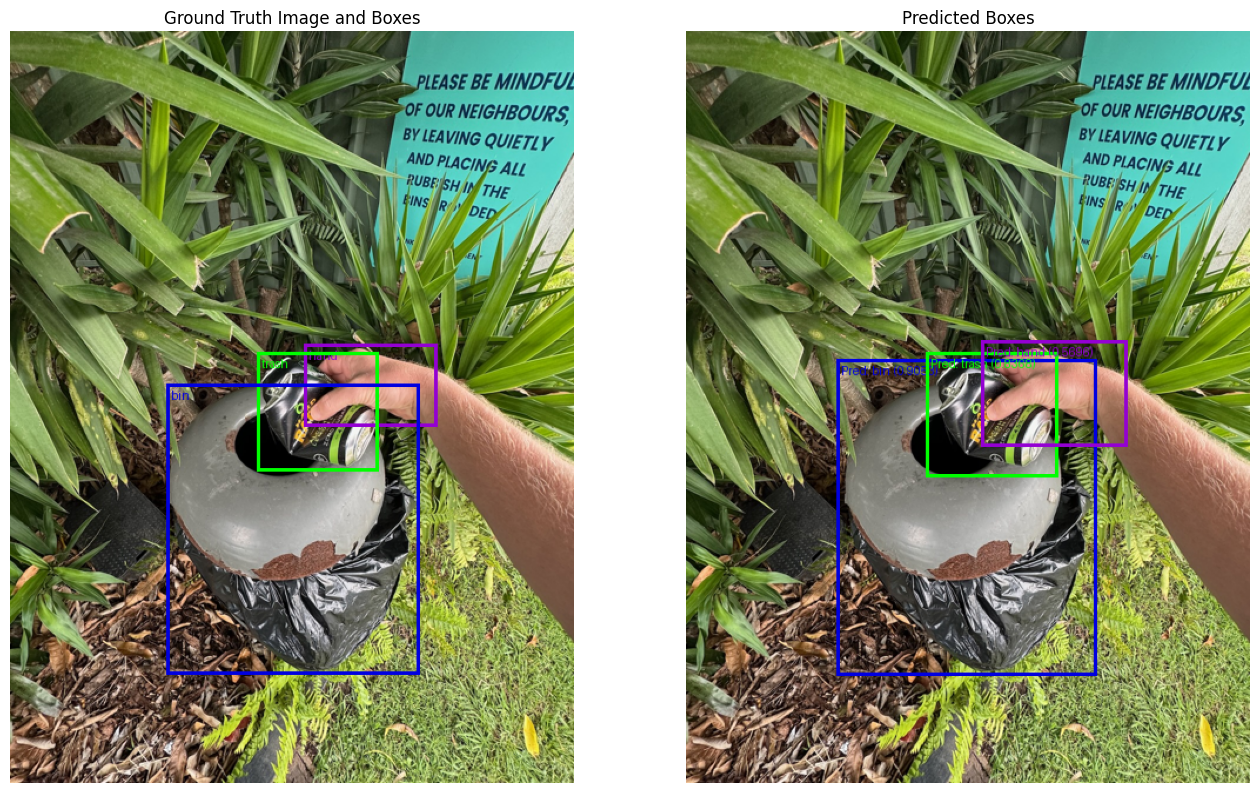

In [ ]:
# Get the truth image
ground_truth_image = half_image(dataset["test"][random_test_pred_index]["image"])

# Get ground boxes and convert CXCYWH -> XYXY (to be in the same format as prediction boxes)
ground_truth_boxes = [convert_bbox_cxcywh_to_xyxy_absolute(boxes=input_box,
                                                           image_size_target=random_test_sample["labels"]["orig_size"]) for input_box in random_test_sample["labels"]["boxes"]]
ground_truth_boxes = torch.stack(half_boxes(ground_truth_boxes))

# Get ground truth box plot image
ground_truth_labels = [id2label[label.item()] for label in random_test_sample["labels"]["class_labels"]]
ground_truth_colours = [colour_palette[label] for label in ground_truth_labels]

# Create ground truth box plot image
test_ground_truth_box_image = to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=ground_truth_image),
        boxes=ground_truth_boxes,
        colors=ground_truth_colours,
        labels=ground_truth_labels,
        width=3
    )
)

# Plot ground truth image and boxes to predicted image and boxes
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 10))
ax[0].imshow(test_ground_truth_box_image)
ax[0].set_title("Ground Truth Image and Boxes")
ax[0].axis(False)
ax[1].imshow(test_pred_box_image)
ax[1].set_title("Predicted Boxes")
ax[1].axis(False)

plt.show()

✅Image saved as test_image.jpg


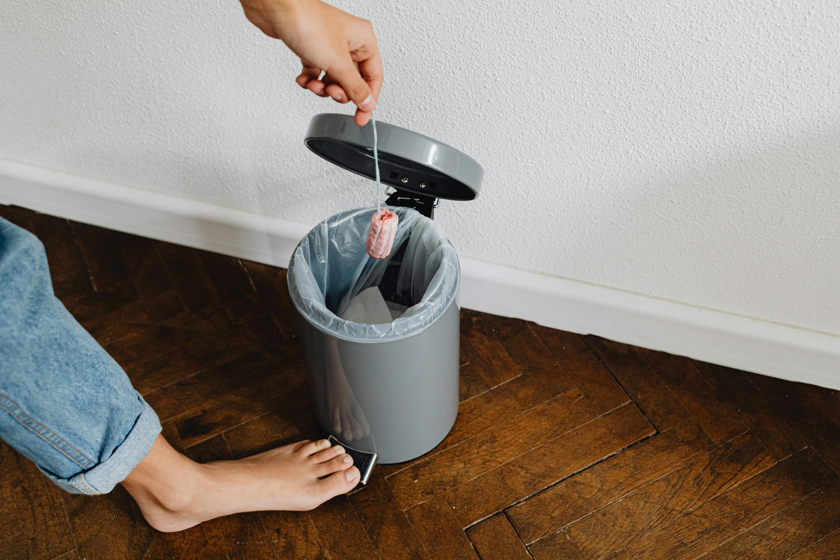

In [ ]:
### Prediction on a random image that is not in the dataset
import requests
from PIL import Image

# An image of a hand with a trash on a bin with it
# url = "https://images.pexels.com/photos/6632867/pexels-photo-6632867.jpeg?cs=srgb&dl=pexels-cup-of-couple-6632867.jpg&fm=jpg"
link = "https://images.pexels.com/photos/7282001/pexels-photo-7282001.jpeg?cs=srgb&dl=pexels-karolina-grabowska-7282001.jpg&fm=jpg"
# link2 = "https://images.pexels.com/photos/9324355/pexels-photo-9324355.jpeg?cs=srgb&dl=pexels-lara-jameson-9324355.jpg&fm=jpg"

image_name = "test_image.jpg"

# Downlaod image
with requests.get(link, stream=True, timeout=20) as request:
  request.raise_for_status()
  with open(image_name, "wb") as file:
    for chunk in request.iter_content(chunk_size=8192):
      file.write(chunk)

print(f"✅Image saved as {image_name}")
image = Image.open(image_name)
for _ in range(3): # Splitting in 3 based on its size
  image = half_image(image)
image

ℹ️ Test image size: tensor([640, 640])
ℹ️ Labels with scores:
Pred: hand (0.8959)
Pred: bin (0.8336)
Pred: hand (0.7419)
Pred: trash (0.4966)


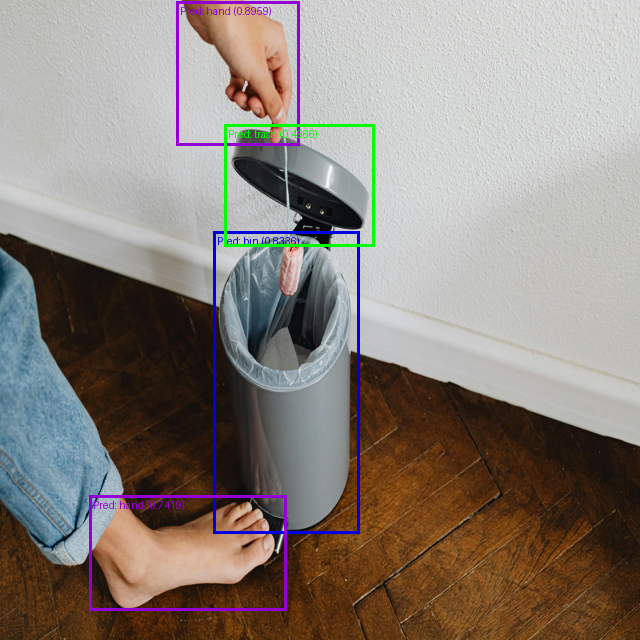

In [ ]:
from pathlib import Path
from PIL import Image

def get_image_dimensions_from_pil(image: Image.Image) -> torch.tensor: # torch.Tensor???
  """
  Convert the dimensions of a PIL image to a PyTorch tensor in the order (height, width).

  Args:
      image (Image.Image): The input PIL image.

  Returns:
      torch.Tensor: A tensor containing the height and width of the image.
  """
  # Get (width, height) of image
  width, height = image.size

  # Convert to tensor in the order (height, width)
  image_dimensions_tensor = torch.tensor([height, width])

  return image_dimensions_tensor

# Get the test image
test_image_pil = Image.open("test_image.jpg").resize(size=(640, 640))

# Preprocess the image
test_image_preprocessed = image_processor.preprocess(images=test_image_pil,
                                                     return_tensors="pt")
# Make predictions on the preprocessed image
random_test_sample_outputs = model(pixel_values=test_image_preprocessed["pixel_values"].to("cuda"), # model expects input [batch_size, color_channels, height, width]
                                   pixel_mask=None)

# Get image original size
test_image_size = get_image_dimensions_from_pil(image=test_image_pil)
print(f"ℹ️ Test image size: {test_image_size}")

# Create the threshold, we can adjust this based on how confident we'd like our model to be about its predictions
THRESHOLD = 0.4

# Post process the predictions
random_test_sample_outputs_post_processed = image_processor.post_process_object_detection(
    outputs=random_test_sample_outputs,
    threshold=THRESHOLD,
    target_sizes=test_image_size.unsqueeze(0) # needs to be same length as batch dimension of the logits (e.g. [[height, width]])
)

# Extract scores, labels and boxes
random_test_sample_pred_scores = random_test_sample_outputs_post_processed[0]["scores"]
random_test_sample_pred_labels = random_test_sample_outputs_post_processed[0]["labels"]
random_test_sample_pred_boxes = random_test_sample_outputs_post_processed[0]["boxes"]

# Create a list of labels to plot on the boxes
random_test_sample_labels_to_plot = [f"Pred: {id2label[label_pred.item()]} ({round(score_pred.item(), 4)})"
                                     for label_pred, score_pred in zip(random_test_sample_pred_labels, random_test_sample_pred_scores)]
random_test_sample_colours_to_plot = [colour_palette[id2label[label_pred.item()]] for label_pred in random_test_sample_pred_labels]

print("ℹ️ Labels with scores:")
for item in random_test_sample_labels_to_plot:
    print(item)

# Plot the predicted boxes on the random test image
to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=test_image_pil),
        colors=random_test_sample_colours_to_plot,
        boxes=random_test_sample_pred_boxes,
        labels=random_test_sample_labels_to_plot,
        width=3
    )
)

- For the images the model is failing on they should be used for training the model, like the above one. Incorporating diverse training data into the pipeline.

## Uploading the model to Hugging Face Hub

In [ ]:
# Save the model
from datetime import datetime # Adding a date when trained the model

# Getting the details to add to model's save path
training_epochs_ = training_args.num_train_epochs
learning_rate_ = "{:.0e}".format(training_args.learning_rate) # Formating into scientific notation (1e-04... 1e-02...)

# Create model save path with some training details
model_save_path = f"models/hf_rt_detrv2_finetuned_trash_object_detection_model_no_aug_{training_epochs_}_epochs_lr_{learning_rate_}"

# Save model
print(f"✅ Saving model to: {model_save_path}")
model_v1_trainer.save_model(model_save_path)

# Adding image_processor to trainer instance to avoid errors and be safe
model_v1_trainer.processing_class = image_processor

✅ Saving model to: models/hf_rt_detrv2_finetuned_trash_object_detection_model_no_aug_10_epochs_lr_1e-04


In [ ]:
# Pushing the model to hub
model_on_hub_url = model_v1_trainer.push_to_hub(commit_message="Uploading the finetuned RT-DETRV2 object detection model.")

In [ ]:
print(f"✅ Model has been uploaded to: {model_on_hub_url.commit_url}")

## Gradio setup

Creating files with the following structure for Hugging Face upload:
```
demos/
└── trash_object_detector/
    ├── app.py
    ├── README.md
    ├── requirements.txt
    └── image_examples/
        ├── trash_example_1.jpeg
        ├── trash_example_2.jpeg
        └── trash_example_3.jpeg
```        

In [ ]:
# Directory to store demo files
from pathlib import Path

# Setup path
demo_path = Path("demos/trash_object_detector")

# The directory
demo_path.mkdir(parents=True, exist_ok=True)

In [ ]:
# model.config

### Making `app.py` file

In [ ]:
%%writefile demos/trash_object_detector/app.py

# 1. Importing the required libraries and packages
import gradio as gr
import torch
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoImageProcessor, AutoModelForObjectDetection

# 2. Setup preprocessing and helper functions
# The model path to load (from Hugging Face)
model_path = "Saint5/rt_detrv2_finetuned_trash_box_detector_v1"

# Loading the model and the processor
image_processor = AutoImageProcessor.from_pretrained(model_path)
model = AutoModelForObjectDetection.from_pretrained(model_path)

# Set the target device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Get the id2label dictionary from the model
id2label = model.config.id2label

# Setting up colour dictionary for plotting boxes with different colours
colour_dict = {
    "bin" : "green",
    "trash" : "blue",
    "hand" : "purple",
    "trash_arm" : "yellow",
    "not_trash" : "red",
    "not_bin" : "red",
    "not_bin" : "red",
}

# 3. Create function to predict on a given image with a given confidence threshold
def predict_on_image(image, conf_threshold):
  model.eval()

  # Make a prediction on target image
  with torch.no_grad():
    inputs = image_processor(images=[image], return_tensors="pt")
    model_outputs = model(**inputs.to(device))

    target_sizes = torch.tensor([[image.size[1], image.size[0]]]) # -> [batch_size, height, width]

    # Post process the raw outputs from the model
    results = image_processor.post_process_object_detection(model_outputs,
                                                            threshold=conf_threshold,
                                                            target_sizes=target_sizes)[0]
  # Return all items in results to CPU (for display with matplotlib)
  for key, value in results.items():
    try:
      result[key] = value.item().cpu()
    except:
      results[key] = value.cpu()

  # 4. Draw the predictions on the target image
  draw = ImageDraw.Draw(image)

  # Get a font from ImageFont
  font = ImageFont.load_default(size=20)

  # Get a class name as text for print out
  detected_class_name_text_labels = []

  # Iterate through the predictions of the model and draw them on the target image
  for box, score, label in zip(results["boxes"], results["scores"], results["labels"]):
    # Create coordinates
    x, y, x2, y2 = tuple(box.tolist())

    # Get label name
    label_name = id2label[label.item()]
    targ_colour = colour_dict[label_name]
    detected_class_name_text_labels.append(label_name)

    # Draw the rectangle
    draw.rectangle(xy=(x, y, x2, y2),
                   outline=targ_colour,
                   width=3)

    # Create a text string to display
    text_string_to_show = f"{label_name} ({round(score.item(), 3)})"

    # Draw the text string on the image
    draw.text(xy=(x, y),
              text=text_string_to_show,
              fill="white",
              font=font)

  # Remove the draw each time
  del draw

  # 5. Create logic for outputting information message
  # Setup set of targets to discover
  target_items = {"trash", "bin", "hand"}
  detected_items = set(detected_class_name_text_labels)

  # If the items are not detected, return notification
  if not detected_items and target_items:
    return_string = (
        f"""No trash, bin or hand detected at confidence threshold {conf_threshold}.
        Try another image or lowering the confidence threshold."""
    )
    print(return_string)
    return image, return_string

  # If there are missing items, say what the missing items are
  missing_items = target_items - detected_items
  if missing_items:
    return_string = (
        f"""Detected the following items: {sorted(detected_items and target_items)} but missing the following in order to get 1 point: {sorted(missing_items)}.
        If this is an error, try another image or alter the confidence threshold.
        Otherwise, the model may need to be updated with better data."""
    )
    print(return_string)
    return image, return_string

  # If all target items are present
  return_string = f"+1 Point!🪙 Found the following items: {sorted(detected_items)}, thank you for cleaning up the area!"
  print(return_string)
  return image, return_string

# 6. Setup the demo application to take in image, make a prediction with the model, return the image with drawn predicitons
# Write a description for the gradio interface
description = """
An object detection system that lets the user upload a picture of them holding trash in their hand and placing it in a bin. The system will be able to detect the hand, trash and the bin. If all the three items are available,
the user get 1 point!

Model used for the system is a finetuned version of [RT-DETRv2](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr_v2#transformers.RTDetrV2Config) on the manually hand labelled [dataset](https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images).
"""

# Create the gradio interface
demo = gr.Interface(
    fn = predict_on_image,
    inputs = [
        gr.Image(type="pil", label="Target Image"),
        gr.Slider(minimum=0, maximum=1, value=0.3, label="Confidence Threshold")
    ],
    outputs=[
        gr.Image(type="pil", label="Image Output"),
        gr.Text(label="Text Output")
    ],
    title = "🗑️🚮 Trash Object Detection Model Demo",
    description=description,
    examples=[
        ["image_examples/trash_example_1.jpeg", 0.3],
        ["image_examples/trash_example_2.jpeg", 0.3],
        ["image_examples/trash_example_3.jpeg", 0.3],
    ],
    cache_examples=True
)

# Launch the demo
demo.launch()

Writing demos/trash_object_detector/app.py


### Making a `requirements.txt` file

In [ ]:
%%writefile demos/trash_object_detector/requirements.txt
timm
gradio
torch
transformers

Writing demos/trash_object_detector/requirements.txt


### Making a `README.md` file

In [ ]:
%%writefile demos/trash_object_detector/README.md
---
title: Trash Object Detection Demo 🚮
emoji: 🗑️
colorFrom: purple
colorTo: blue
sdk: gradio
sdk_version: 5.34.0
app_file: app.py
license: mit
---

# 🚮 Trash Object Detector
Object detection demo to detect `trash`, `bin`, `hand`, `trash_arm`, `not_trash`, `not_bin`, `not_hand`.

Used as example to encourage people to clean up their local area.

If `trash`, `hand`, `bin` all dected = +1 point.

## Dataset
The model is trained on a custom dataset, hand-labelled of people picking up trash and placing it in a bin.

The dataset is found in Hugging Face as [`mrdbourke/trashify_manual_labelled_images`](https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images).

Writing demos/trash_object_detector/README.md


### Making an examples folder

In [ ]:
# A directory to save examples to
from pathlib import Path

demo_example_dir = "demos/trash_object_detector/image_examples/"
Path(demo_example_dir).mkdir(exist_ok=True, parents=True)

In [ ]:
# Loading the example images to be used
from datasets import load_dataset

example_images = load_dataset("mrdbourke/trashify_examples")
example_images

README.md:   0%|          | 0.00/661 [00:00<?, ?B/s]

trashify_examples/trashify_example_1.jpe(…):   0%|          | 0.00/501k [00:00<?, ?B/s]

trashify_examples/trashify_example_2.jpe(…):   0%|          | 0.00/1.07M [00:00<?, ?B/s]

trashify_examples/trashify_example_3.jpe(…):   0%|          | 0.00/927k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 3
    })
})

In [ ]:
for i, sample in enumerate(example_images["train"]):
  save_path = Path(demo_example_dir, f"trash_example_{i+1}.jpeg")
  print(f"ℹ️ Saving image to {save_path}")
  sample["image"].save(save_path)

ℹ️ Saving image to demos/trash_object_detector/image_examples/trash_example_1.jpeg
ℹ️ Saving image to demos/trash_object_detector/image_examples/trash_example_2.jpeg
ℹ️ Saving image to demos/trash_object_detector/image_examples/trash_example_3.jpeg


In [ ]:
!ls demos/trash_object_detector/

app.py	image_examples	README.md  requirements.txt


## Uploading the demo to Hugging Face Space

In [ ]:
# 1. Import the required methods for uploading to the Hugging Face Hub
from huggingface_hub import create_repo, get_full_repo_name, upload_file, upload_folder

# 2. Define the parameters to use for the upload
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "demos/trash_object_detector"
HF_TARGET_SPACE_NAME = "trash_object_detection_demo" ###
HF_REPO_TYPE = "space"
HF_SPACE_SDK = "gradio"
HF_TOKEN = "" # your hugging face token key (optional)

# 3. Create a space repository on Hugging Face Hub
print(f"ℹ️ Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    # token=HF_TOKEN,
    repo_type=HF_REPO_TYPE,
    private=False,
    space_sdk=HF_SPACE_SDK,
    exist_ok=True # Error not to be raised if repo_id already exists
)

# 4. Get the full repository name
full_hf_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"ℹ️ Full Hugging Face repo name: {full_hf_repo_name}")

# 5. Upload the demo folder
print(f"ℹ️ Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {full_hf_repo_name}")
folder_upload_url = upload_folder(
    repo_id=full_hf_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo=".", # upload the folder to the root directory (default)
    # token=HF_TOKEN,
    repo_type=HF_REPO_TYPE,
    commit_message="Uploading the trash object detection system model app.py"
)

print(f"✅ Demo Folder successfully uploaded with commit url: {folder_upload_url}")

## Testing the demo

In [ ]:
from IPython.display import HTML

HTML(data='''
<iframe
	src="https://saint5-trash-object-detection-demo.hf.space"
	frameborder="0"
	width="950"
	height="1000"
></iframe>
''')